In [2]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [10]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [11]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [12]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [75]:
def cost_execution(params):
    params = np.reshape(params, (2, 1))

    global iterations

    cost = CVaRsamp(params, alpha=a, n=num_of_samples)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)
    cost_list.append(cost)

    iterations += 1
    return cost

In [98]:
alphas = [0.05, 0.10, 0.25, 1.00]
num_of_samples = 32 #number of samples from the quantum computer/probability distribution
initial_params = np.array([[0.1],[0.1]], requires_grad = True) #first vector is alphas second is betas, (2,1) for P=1, (2,2) for p=2, (2,3) for p=3...
number_of_tests = 1000 #number of times you want to run the tests for each alpha, for statistical analysis this should be high
tolerance = 0.001 #Tolerance for when minimizer is done optimizing


data_library = {}
for a in alphas:
    print('Alpha is now :'+ str(a))
    print("="*100)
    counter = 0
    prob_list_list = []
    cost_list_list = []
    iter_needed_list = []
    
    for j in range(number_of_tests):
        iterations = 0
        params_list = []
        prob_list = []
        cost_list = []
        
        out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)
        out_params = np.reshape(out["x"], (2, len(initial_params[0])))
        print(out["x"])
        print(out["success"])
        probs = get_probs(out_params)
        ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states
        
        for i in range(len(params_list)):
            p = get_probs(params_list[i])
            prob_list.append(float(np.sum(p[ground_states_i])))

        prob_list_list.append(prob_list)
        cost_list_list.append(cost_list)
        iter_needed_list.append(iterations)
        
        counter+=1
        print(str(iterations) + ' iterations needed. CVaR cost ended at: ' + str(cost_list[-1]))
        print('Try ' + str(j+1) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
        print("="*50)
    
    data = {
      "CVaR cost": cost_list_list,
      "Ground state probability": prob_list_list,
      "Iterations needed": iter_needed_list
    }
    
    var_name = "data_for_alpha_%s" % a
    data_library[var_name] = data
    
        

Alpha is now :0.05
Cost at Step 0: -4.2


/var/folders/cw/p649yvnd6tl_8jn4s2cchc7m0000gn/T/ipykernel_15687/3411379684.py:23: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)


[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 1: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.10094444 0.09967131]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 2: Success probability of training:  0.025686413091161722
Cost at Step 0: -6.6
[0.1009978  0.09993366]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 3: Success probability of training:  0.008991405522762536
Cost at Step 0: -6.6
[0.1   0.101]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 4: Success probability of training:  0.008988465692090147
Cost at Step 0: -3.1
[1.6 0.1]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 5: Success probability of training:  0.021271943329702246
Cost at Step 0: -4.5
[0.10049243 0.10868285]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 6: Success probability of training:  0.008580312564731638
Cost at Step 0: -4.5
[0.10096107 1.09972369]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 7: S

[1.09951972 0.09912288]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 42: Success probability of training:  0.025561134441800897
Cost at Step 0: -3.5
[1.60054735 0.1008369 ]
True
22 iterations needed. CVaR cost ended at: -6.6
Try 43: Success probability of training:  0.02129412678021668
Cost at Step 0: -3.5
[0.1 1.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 44: Success probability of training:  0.045968061754130846
Cost at Step 0: -3.5
[1.1   0.225]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 45: Success probability of training:  0.043714745180803614
Cost at Step 0: -6.6
[0.09910557 0.09955279]
True
22 iterations needed. CVaR cost ended at: -4.2
Try 46: Success probability of training:  0.009108383910654883
Cost at Step 0: -4.2
[2.1009995  0.09996829]
True
21 iterations needed. CVaR cost ended at: -3.5
Try 47: Success probability of training:  0.01444400670188564
Cost at Step 0: -3.4
[1.10094829 1.10031741]
True
22 iterations needed. CVaR cost ended

[ 1.80710678 -0.60710678]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 82: Success probability of training:  0.025720489086736416
Cost at Step 0: -6.6
[0.10078266 0.10062245]
True
22 iterations needed. CVaR cost ended at: -4.2
Try 83: Success probability of training:  0.00896719546754264
Cost at Step 0: -4.2
[0.09972 1.10096]
True
15 iterations needed. CVaR cost ended at: -4.5
Try 84: Success probability of training:  0.045891657580523756
Cost at Step 0: -4.5
[1.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 85: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.2
[1.09959223 0.09908692]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 86: Success probability of training:  0.025559417587630223
Cost at Step 0: -4.2
[1.10097074 1.09975987]
True
23 iterations needed. CVaR cost ended at: -4.2
Try 87: Success probability of training:  0.007516059160096358
Cost at Step 0: -4.2
[ 1.30977168 -0.87683228]
True
19 iterations needed. CVaR c

[ 0.1  -0.15]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 123: Success probability of training:  0.030180749895145492
Cost at Step 0: -6.6
[0.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 124: Success probability of training:  0.009039367370204977
Cost at Step 0: -3.5
[1.1   0.225]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 125: Success probability of training:  0.043714745180803614
Cost at Step 0: -6.6
[0.1005947  0.09919605]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 126: Success probability of training:  0.00904998671018985
Cost at Step 0: -4.5
[0.09957007 1.10090286]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 127: Success probability of training:  0.0458268732578833
Cost at Step 0: -4.5
[0.1 1.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 128: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.5
[1.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 129: Success probab

[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 164: Success probability of training:  0.025691215924684978
Cost at Step 0: -6.6
[0.10066898 0.09925672]
True
20 iterations needed. CVaR cost ended at: -2.1
Try 165: Success probability of training:  0.009043060045091594
Cost at Step 0: -4.5
[1.1 0.1]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 166: Success probability of training:  0.025691215924684978
Cost at Step 0: -6.6
[0.09900761 0.10012313]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 167: Success probability of training:  0.009084478412977423
Cost at Step 0: -4.5
[1.10088441 0.09953328]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 168: Success probability of training:  0.02566649820275617
Cost at Step 0: -4.5
[0.1 1.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 169: Success probability of training:  0.045968061754130846
Cost at Step 0: -6.6
[0.09956137 0.10089867]
True
22 iterations needed. CVaR cost ended at: -4.2
T

[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 204: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.1   0.101]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 205: Success probability of training:  0.02581856044348292
Cost at Step 0: -4.2
[1.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 206: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.2
[1.1 0.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 207: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.09900223 0.1000668 ]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 208: Success probability of training:  0.025660302678218436
Cost at Step 0: -3.5
[1.10047046 0.10088242]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 209: Success probability of training:  0.025822228869490902
Cost at Step 0: -4.5
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 210: Success probabil

19 iterations needed. CVaR cost ended at: -6.6
Try 244: Success probability of training:  0.02581862554920498
Cost at Step 0: -4.5
[1.1009318  0.10036298]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 245: Success probability of training:  0.02577411166040297
Cost at Step 0: -6.6
[0.10084517 0.0994655 ]
True
18 iterations needed. CVaR cost ended at: -3.4
Try 246: Success probability of training:  0.00902329390190933
Cost at Step 0: -4.2
[1.6 0.1]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 247: Success probability of training:  0.021271943329702246
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 248: Success probability of training:  0.045968061754130846
Cost at Step 0: -6.6
[0.10008771 0.10099615]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 249: Success probability of training:  0.008984110030033375
Cost at Step 0: -4.5
[1.09948513 0.09914273]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 250: Success p

[0.10044721 0.10089443]
True
19 iterations needed. CVaR cost ended at: -3.4
Try 284: Success probability of training:  0.008970654969572108
Cost at Step 0: -6.6
[0.09935174 0.09923858]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 285: Success probability of training:  0.009111691110529972
Cost at Step 0: -2.1
[1.09980819 1.10098143]
True
18 iterations needed. CVaR cost ended at: -4.2
Try 286: Success probability of training:  0.007667866418310683
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 287: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.5
[1.1 0.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 288: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.1 0.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 289: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 290: Succe

[1.0995386  1.10088719]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 325: Success probability of training:  0.007685639788748182
Cost at Step 0: -4.2
[1.1 0.1]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 326: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[0.10049614 1.10086824]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 327: Success probability of training:  0.04621170846605287
Cost at Step 0: -3.4
[1.1   0.101]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 328: Success probability of training:  0.02581856044348292
Cost at Step 0: -4.5
[0.1 1.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 329: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[1.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 330: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.10048028 0.10087712]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 331: Suc

[0.1   0.101]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 366: Success probability of training:  0.008988465692090147
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 367: Success probability of training:  0.045968061754130846
Cost at Step 0: -6.6
[0.09927413 0.10068783]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 368: Success probability of training:  0.009042008540124656
Cost at Step 0: -6.6
[0.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 369: Success probability of training:  0.009039367370204977
Cost at Step 0: -6.6
[0.09939396 0.10079543]
True
22 iterations needed. CVaR cost ended at: -3.1
Try 370: Success probability of training:  0.009030326529361157
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 371: Success probability of training:  0.045968061754130846
Cost at Step 0: -3.5
[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 372: Success probabi

[0.09905829 0.09966357]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 407: Success probability of training:  0.00910519337830229
Cost at Step 0: -6.6
[0.1008077  0.09941041]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 408: Success probability of training:  0.009028046782928584
Cost at Step 0: -6.6
[0.10067306 0.09926041]
True
20 iterations needed. CVaR cost ended at: -3.5
Try 409: Success probability of training:  0.00904266144819666
Cost at Step 0: -4.5
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 410: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[1.1 1.1]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 411: Success probability of training:  0.007606229278312782
Cost at Step 0: -4.5
[0.10220022 0.10189925]
True
16 iterations needed. CVaR cost ended at: -4.2
Try 412: Success probability of training:  0.008828850583475531
Cost at Step 0: -6.6
[0.101 0.1  ]
True
21 iterations needed. CVaR cost ended at: -4.

20 iterations needed. CVaR cost ended at: -4.5
Try 447: Success probability of training:  0.025561524102668026
Cost at Step 0: -6.6
[0.09937824 0.10078321]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 448: Success probability of training:  0.009031763267973144
Cost at Step 0: -4.2
[0.8574549 0.0375696]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 449: Success probability of training:  0.01392737406489973
Cost at Step 0: -4.5
[1.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 450: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.10090995 0.09958529]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 451: Success probability of training:  0.025674114476517615
Cost at Step 0: -4.5
[0.1 1.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 452: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.5
[1.09989632 0.10099461]
True
21 iterations needed. CVaR cost ended at: -3.5
Try 453: Success p

[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 488: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[1.14419417 0.05580583]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 489: Success probability of training:  0.02139940097931632
Cost at Step 0: -4.5
[1.1 0.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 490: Success probability of training:  0.025691215924684978
Cost at Step 0: -6.6
[0.10022922 0.10097337]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 491: Success probability of training:  0.008977928838438409
Cost at Step 0: -3.1
[1.1 0.1]
True
12 iterations needed. CVaR cost ended at: -6.6
Try 492: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.1009889  0.10014855]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 493: Success probability of training:  0.025748988079940992
Cost at Step 0: -4.5
[1.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 494: Succes

[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 528: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[1.0994453  0.06791795]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 529: Success probability of training:  0.021846753040280234
Cost at Step 0: -6.6
[0.099 0.1  ]
True
18 iterations needed. CVaR cost ended at: -3.1
Try 530: Success probability of training:  0.009091120702503296
Cost at Step 0: -6.6
[0.09911531 0.09953383]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 531: Success probability of training:  0.009108845758692629
Cost at Step 0: -6.6
[0.10038033 0.10092485]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 532: Success probability of training:  0.008972568400179959
Cost at Step 0: -4.5
[1.1   0.099]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 533: Success probability of training:  0.025564322681430864
Cost at Step 0: -4.5
[0.1001527  1.10098827]
True
17 iterations needed. CVaR cost ended a

[1.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 568: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.2
[1.10052271 1.09914749]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 569: Success probability of training:  0.0075236804629456
Cost at Step 0: -6.6
[0.10063498 0.09922747]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 570: Success probability of training:  0.009046306847468226
Cost at Step 0: -4.2
[2.1005603  0.10082829]
True
23 iterations needed. CVaR cost ended at: -4.5
Try 571: Success probability of training:  0.014447969702908514
Cost at Step 0: -3.5
[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 572: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 573: Success probability of training:  0.045968061754130846
Cost at Step 0: -3.5
[1.1 0.1]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 574: Success

19 iterations needed. CVaR cost ended at: -6.6
Try 608: Success probability of training:  0.008975702644824645
Cost at Step 0: -4.5
[0.1 1.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 609: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.5
[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 610: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.09903246 0.09974728]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 611: Success probability of training:  0.025621021402773364
Cost at Step 0: -4.5
[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 612: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[0.10078344 0.22562147]
True
20 iterations needed. CVaR cost ended at: -3.5
Try 613: Success probability of training:  0.004588768676481527
Cost at Step 0: -6.6
[0.09901007 0.10014157]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 614: Success probability 

[1.1 0.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 648: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.10061217 0.10079072]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 649: Success probability of training:  0.025816127942822703
Cost at Step 0: -3.5
[ 1.02719174 -0.13921866]
True
25 iterations needed. CVaR cost ended at: -6.6
Try 650: Success probability of training:  0.014772596895754463
Cost at Step 0: -4.2
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 651: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[2.1 0.1]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 652: Success probability of training:  0.014463595687841412
Cost at Step 0: -4.2
[ 1.24142136 -0.88994949]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 653: Success probability of training:  0.0566940095690261
Cost at Step 0: -4.5
[1.09999051 0.09900004]
True
19 iterations needed. CVaR cost ended at: -6.

[1.09917208 0.10056085]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 688: Success probability of training:  0.025729730407825703
Cost at Step 0: -4.5
[1.09932191 0.10073498]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 689: Success probability of training:  0.02575782412009161
Cost at Step 0: -4.5
[1.09907445 0.10037861]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 690: Success probability of training:  0.025702711929170414
Cost at Step 0: -4.2
[1.1   0.099]
True
18 iterations needed. CVaR cost ended at: -4.2
Try 691: Success probability of training:  0.025564322681430864
Cost at Step 0: -4.5
[1.1 0.1]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 692: Success probability of training:  0.025691215924684978
Cost at Step 0: -6.6
[0.10092163 0.09961193]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 693: Success probability of training:  0.009011844440415454
Cost at Step 0: -4.5
[1.09955767 0.09910315]
True
21 iterations needed. CVaR cos

[0.10080457 0.09940615]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 728: Success probability of training:  0.009028426537703759
Cost at Step 0: -4.5
[ 0.101 -0.15 ]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 729: Success probability of training:  0.030353284041808145
Cost at Step 0: -4.5
[1.10098184 0.10018972]
True
20 iterations needed. CVaR cost ended at: -3.5
Try 730: Success probability of training:  0.025753963116859752
Cost at Step 0: -4.2
[1.1 0.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 731: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.1 0.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 732: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.2
[0.09972 1.10096]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 733: Success probability of training:  0.045891657580523756
Cost at Step 0: -3.5
[0.87021374 1.00152018]
True
20 iterations needed. CVaR cost ended at: -6.6


[1.1 0.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 768: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.1
[1.47212329 2.02915734]
True
15 iterations needed. CVaR cost ended at: -3.5
Try 769: Success probability of training:  0.03170526857601702
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 770: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[2.10099516 0.10009827]
True
26 iterations needed. CVaR cost ended at: -3.5
Try 771: Success probability of training:  0.01444333936509847
Cost at Step 0: -4.5
[0.10042993 1.09909714]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 772: Success probability of training:  0.046108714495070986
Cost at Step 0: -6.6
[0.09963112 0.10092948]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 773: Success probability of training:  0.009011203415126755
Cost at Step 0: -3.5
[1.09912422 0.10048272]
True
20 iterations needed. CVaR cost end

[0.10085234 0.10052298]
True
22 iterations needed. CVaR cost ended at: -3.5
Try 808: Success probability of training:  0.008968686957614436
Cost at Step 0: -6.6
[0.09902811 0.09976457]
True
23 iterations needed. CVaR cost ended at: -1.8
Try 809: Success probability of training:  0.009101620951103551
Cost at Step 0: -6.6
[0.09902002 0.1001991 ]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 810: Success probability of training:  0.009079981448239956
Cost at Step 0: -3.5
[1.1 0.1]
True
13 iterations needed. CVaR cost ended at: -6.6
Try 811: Success probability of training:  0.025691215924684978
Cost at Step 0: -2.1
[1.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 812: Success probability of training:  0.025691215924684978
Cost at Step 0: -3.5
[1.099 0.1  ]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 813: Success probability of training:  0.025651748557919147
Cost at Step 0: -4.5
[0.1 1.1]
True
13 iterations needed. CVaR cost ended at: -6.6
Try 814: S

20 iterations needed. CVaR cost ended at: -4.5
Try 848: Success probability of training:  0.009094028959750908
Cost at Step 0: -4.5
[0.1 1.1]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 849: Success probability of training:  0.045968061754130846
Cost at Step 0: -6.6
[0.09923794 0.10064751]
True
24 iterations needed. CVaR cost ended at: -4.5
Try 850: Success probability of training:  0.009045932567819413
Cost at Step 0: -4.2
[1.6   0.101]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 851: Success probability of training:  0.021313950006319714
Cost at Step 0: -6.6
[0.09927366 0.09931266]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 852: Success probability of training:  0.009111937448946617
Cost at Step 0: -6.6
[0.10048383 0.10087516]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 853: Success probability of training:  0.008969741303509294
Cost at Step 0: -4.2
[0.1 1.1]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 854: Success probabil

[1.09926922 0.09931738]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 888: Success probability of training:  0.025575930221690676
Cost at Step 0: -4.2
[0.1 1.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 889: Success probability of training:  0.045968061754130846
Cost at Step 0: -4.2
[1.10044721 0.10089443]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 890: Success probability of training:  0.025822840883742135
Cost at Step 0: -6.6
[0.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 891: Success probability of training:  0.009039367370204977
Cost at Step 0: -6.6
[0.09910557 0.09955279]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 892: Success probability of training:  0.009108383910654883
Cost at Step 0: -4.5
[-0.9  0.1]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 893: Success probability of training:  0.0215458887609452
Cost at Step 0: -2.1
[1.10016617 0.0990139 ]
True
19 iterations needed. CVaR cost ended at: -6.6


[0.09994412 0.10099844]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 929: Success probability of training:  0.00899144562077736
Cost at Step 0: -3.5
[1.1   0.225]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 930: Success probability of training:  0.043714745180803614
Cost at Step 0: -4.5
[1.1 0.1]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 931: Success probability of training:  0.025691215924684978
Cost at Step 0: -4.5
[1.1   0.101]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 932: Success probability of training:  0.02581856044348292
Cost at Step 0: -2.1
[1.101 0.1  ]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 933: Success probability of training:  0.02573047357160329
Cost at Step 0: -4.5
[1.09936038 0.1007687 ]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 934: Success probability of training:  0.025763643951465975
Cost at Step 0: -4.5
[0.1 1.1]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 935: Success pr

[1.0991052  0.10044647]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 970: Success probability of training:  0.025712547033095536
Cost at Step 0: -6.6
[0.09955279 0.10089443]
True
17 iterations needed. CVaR cost ended at: -2.4
Try 971: Success probability of training:  0.009017052271500526
Cost at Step 0: -3.4
[1.10097879 0.10020486]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 972: Success probability of training:  0.025755776544540712
Cost at Step 0: -4.2
[0.1 1.1]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 973: Success probability of training:  0.045968061754130846
Cost at Step 0: -6.6
[0.10039446 0.10091891]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 974: Success probability of training:  0.008972139013263797
Cost at Step 0: -6.6
[0.1   0.099]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 975: Success probability of training:  0.009090554595381646
Cost at Step 0: -6.6
[0.09940758 0.09919437]
True
21 iterations needed. CVaR co

[1.26944983 0.35027427]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 9: Success probability of training:  0.06813669851419712
Cost at Step 0: -5.2
[ 0.10053682 -0.1491563 ]
True
20 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 10: Success probability of training:  0.030183495302510688
Cost at Step 0: -3.3333333333333335
[1.10068312 0.10073031]
True
19 iterations needed. CVaR cost ended at: -3.6999999999999997
Try 11: Success probability of training:  0.025811216319728863
Cost at Step 0: -3.6
[ 3.94914685 -0.71400916]
True
26 iterations needed. CVaR cost ended at: -5.566666666666666
Try 12: Success probability of training:  0.04844744717628753
Cost at Step 0: -4.033333333333333
[1.23452742 0.31171899]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 13: Success probability of training:  0.0642969575139311
Cost at Step 0: -3.6999999999999997
[0.22239913 1.07463364]
True
19 iterations needed. CVaR cost ended at: -6.59999999999

[ 1.97755738 -0.32025751]
True
22 iterations needed. CVaR cost ended at: -5.2
Try 45: Success probability of training:  0.018461845124121457
Cost at Step 0: -2.5666666666666664
[0.67289015 0.96878783]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 46: Success probability of training:  0.06452373564514766
Cost at Step 0: -3.233333333333333
[0.60478135 1.16898177]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 47: Success probability of training:  0.150642445504346
Cost at Step 0: -4.3999999999999995
[1.10880736 0.09975141]
True
20 iterations needed. CVaR cost ended at: -3.6666666666666665
Try 48: Success probability of training:  0.025997195474881173
Cost at Step 0: -3.3666666666666667
[1.14107383 0.3466028 ]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 49: Success probability of training:  0.06398064997896157
Cost at Step 0: -5.1000000000000005
[-0.01969977  0.31850194]
True
20 iterations needed. CVaR cost ended at:

[1.20274685 0.02707833]
True
20 iterations needed. CVaR cost ended at: -4.066666666666666
Try 81: Success probability of training:  0.018575677379372935
Cost at Step 0: -3.233333333333334
[1.12530095 0.15617444]
True
21 iterations needed. CVaR cost ended at: -5.0
Try 82: Success probability of training:  0.03490185980599156
Cost at Step 0: -4.066666666666666
[1.09997409 0.10099966]
True
19 iterations needed. CVaR cost ended at: -5.2
Try 83: Success probability of training:  0.025817487279868934
Cost at Step 0: -3.3666666666666667
[2.118904   1.73003233]
True
21 iterations needed. CVaR cost ended at: -3.3666666666666667
Try 84: Success probability of training:  0.014142296610564202
Cost at Step 0: -4.833333333333333
[0.59477408 1.1721014 ]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 85: Success probability of training:  0.15546299178823753
Cost at Step 0: -5.8999999999999995
[1.10085171 0.10052401]
True
19 iterations needed. CVaR cost ended at: -5.5333333333333

[0.10089814 1.10043972]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 117: Success probability of training:  0.04636181216988195
Cost at Step 0: -4.5
[-0.48549055  1.91067923]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 118: Success probability of training:  0.18522620400124173
Cost at Step 0: -3.3333333333333335
[1.09992636 0.09900271]
True
20 iterations needed. CVaR cost ended at: -5.2
Try 119: Success probability of training:  0.025561797414473904
Cost at Step 0: -3.0
[0.60679827 1.02379391]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 120: Success probability of training:  0.10480209435518041
Cost at Step 0: -4.033333333333333
[1.1759149  0.33817713]
True
22 iterations needed. CVaR cost ended at: -5.2
Try 121: Success probability of training:  0.06640130040197716
Cost at Step 0: -4.5
[-0.1495133   1.09912643]
True
21 iterations needed. CVaR cost ended at: -2.0666666666666664
Try 122: Success probability of t

16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 152: Success probability of training:  0.15585394463576804
Cost at Step 0: -3.8333333333333335
[1.25397978 0.29690803]
True
21 iterations needed. CVaR cost ended at: -5.2
Try 153: Success probability of training:  0.061473974301516535
Cost at Step 0: -4.766666666666667
[-0.34958157 -0.91680525]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 154: Success probability of training:  0.0880166613179302
Cost at Step 0: -4.3999999999999995
[1.15294827 0.46252145]
True
18 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 155: Success probability of training:  0.0702561251343671
Cost at Step 0: -5.0
[-0.25219583  0.23993594]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 156: Success probability of training:  0.09431893796147292
Cost at Step 0: -3.966666666666667
[1.09924404 0.09934538]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 157: Success prob

[1.19807272 0.32996593]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 187: Success probability of training:  0.06655475238849197
Cost at Step 0: -4.133333333333334
[0.1007856  1.10061874]
True
23 iterations needed. CVaR cost ended at: -4.2
Try 188: Success probability of training:  0.0463222890030973
Cost at Step 0: -3.466666666666667
[ 1.89472777 -0.56666113]
True
24 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 189: Success probability of training:  0.028600031314989453
Cost at Step 0: -3.0
[0.62722815 1.2627476 ]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 190: Success probability of training:  0.13221646051486527
Cost at Step 0: -4.733333333333333
[1.09933785 0.09925063]
True
19 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 191: Success probability of training:  0.025570176081647238
Cost at Step 0: -3.6
[ 1.89687181 -0.50292776]
True
21 iterations needed. CVaR cost ended at: -5.2
Try 192: Success p

23 iterations needed. CVaR cost ended at: -4.833333333333333
Try 222: Success probability of training:  0.016648879286335093
Cost at Step 0: -2.7000000000000006
[ 0.90111557 -0.0523827 ]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 223: Success probability of training:  0.018012055788257444
Cost at Step 0: -3.3333333333333335
[ 1.79538932 -0.58005094]
True
26 iterations needed. CVaR cost ended at: -3.4333333333333336
Try 224: Success probability of training:  0.025594739807993015
Cost at Step 0: -5.566666666666666
[0.32304559 0.98641764]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 225: Success probability of training:  0.11849795995578119
Cost at Step 0: -4.033333333333333
[1.41657489 2.04962112]
True
22 iterations needed. CVaR cost ended at: -4.866666666666666
Try 226: Success probability of training:  0.04744495094857405
Cost at Step 0: -3.966666666666667
[0.59316225 1.0175925 ]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try

[1.08307271 0.09264433]
True
20 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 258: Success probability of training:  0.024126336560322342
Cost at Step 0: -4.5
[1.18741265 0.3340902 ]
True
23 iterations needed. CVaR cost ended at: -4.066666666666666
Try 259: Success probability of training:  0.06661092450665787
Cost at Step 0: -4.3
[-0.70096583  1.70025917]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 260: Success probability of training:  0.047535598212184005
Cost at Step 0: -5.566666666666666
[0.1130007  0.10669977]
True
20 iterations needed. CVaR cost ended at: -3.3666666666666667
Try 261: Success probability of training:  0.008033552705791255
Cost at Step 0: -3.233333333333333
[0.67119024 1.27429216]
True
23 iterations needed. CVaR cost ended at: -6.599999999999999
Try 262: Success probability of training:  0.1117405768995864
Cost at Step 0: -3.8000000000000003
[1.10462227 0.0975134 ]
True
25 iterations needed. CVaR cost ended at: -5.2
Try 

[1.18073064 0.33660635]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 293: Success probability of training:  0.06653486031077095
Cost at Step 0: -5.8999999999999995
[0.0992812  0.10069521]
True
19 iterations needed. CVaR cost ended at: -2.766666666666667
Try 294: Success probability of training:  0.009041266739976368
Cost at Step 0: -3.3333333333333335
[1.10052439 0.10085148]
True
19 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 295: Success probability of training:  0.02582041328829911
Cost at Step 0: -3.8333333333333335
[1.20395612 0.39374916]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 296: Success probability of training:  0.07387508727307716
Cost at Step 0: -3.1666666666666665
[1.3123233 0.3872869]
True
29 iterations needed. CVaR cost ended at: -3.4333333333333336
Try 297: Success probability of training:  0.06746025046653764
Cost at Step 0: -3.3333333333333335
[ 1.93284146 -0.4553118 ]
True
20 iterations needed. C

[1.16151228 0.34147961]
True
22 iterations needed. CVaR cost ended at: -4.833333333333333
Try 328: Success probability of training:  0.06560836207926664
Cost at Step 0: -4.3999999999999995
[0.15902167 1.11732756]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 329: Success probability of training:  0.07539689260479204
Cost at Step 0: -1.6333333333333335
[2.09979516 1.17302494]
True
25 iterations needed. CVaR cost ended at: -3.6999999999999997
Try 330: Success probability of training:  0.007965835201835638
Cost at Step 0: -4.866666666666666
[0.10270346 0.11576918]
True
21 iterations needed. CVaR cost ended at: -5.0
Try 331: Success probability of training:  0.008120170599394069
Cost at Step 0: -3.8333333333333335
[1.19330954 0.29231694]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 332: Success probability of training:  0.060866441953651276
Cost at Step 0: -2.3000000000000003
[1.10055049 0.10083484]
True
19 iterations needed. CVaR cost ended

[ 1.17797068 -0.00153279]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 364: Success probability of training:  0.015478945238346167
Cost at Step 0: -3.6
[1.50872601 0.23979596]
True
26 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 365: Success probability of training:  0.02881102906055305
Cost at Step 0: -5.0
[1.11269931 0.35000391]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 366: Success probability of training:  0.06043718402321664
Cost at Step 0: -4.033333333333333
[0.46209598 1.1644282 ]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 367: Success probability of training:  0.19630628762366828
Cost at Step 0: -2.1999999999999997
[ 1.84660096 -0.56495252]
True
20 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 368: Success probability of training:  0.02876585891490474
Cost at Step 0: -3.933333333333333
[1.30773412 0.46995596]
True
24 iterations needed. CVaR cost ended at: -6.599999999999999
Try 369: Success p

[ 2.02563846 -0.28047106]
True
20 iterations needed. CVaR cost ended at: -5.0
Try 400: Success probability of training:  0.014801718355144829
Cost at Step 0: -3.466666666666667
[0.62444212 1.25441729]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 401: Success probability of training:  0.13539823125004874
Cost at Step 0: -2.8666666666666667
[ 2.09034175 -0.03864784]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 402: Success probability of training:  0.015749830905679055
Cost at Step 0: -5.1000000000000005
[ 1.46195704 -0.83229839]
True
20 iterations needed. CVaR cost ended at: -5.2
Try 403: Success probability of training:  0.02219082088942635
Cost at Step 0: -4.533333333333333
[1.2609798  0.29206152]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 404: Success probability of training:  0.06041463380952547
Cost at Step 0: -3.1333333333333333
[1.11085069 0.34956645]
True
21 iterations needed. CVaR cost ended at: -5.8
Try 405: Succes

[0.0996473  1.09906426]
True
22 iterations needed. CVaR cost ended at: -5.0
Try 436: Success probability of training:  0.04578169231823314
Cost at Step 0: -4.833333333333333
[1.04012049 0.06872895]
True
23 iterations needed. CVaR cost ended at: -3.8000000000000003
Try 437: Success probability of training:  0.020131348041769227
Cost at Step 0: -3.6999999999999997
[0.64438809 1.30595579]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 438: Success probability of training:  0.11230309194085768
Cost at Step 0: -4.066666666666666
[1.10068821 0.10072552]
True
19 iterations needed. CVaR cost ended at: -5.2
Try 439: Success probability of training:  0.02581080515185707
Cost at Step 0: -3.9333333333333336
[0.22138322 1.07014845]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 440: Success probability of training:  0.10428043697405431
Cost at Step 0: -3.8333333333333335
[ 2.08322478 -0.07394244]
True
25 iterations needed. CVaR cost ended at: -4.8666666

[0.09906927 1.1003657 ]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 472: Success probability of training:  0.0455965775944431
Cost at Step 0: -3.6999999999999997
[-0.37058824  1.98235294]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 473: Success probability of training:  0.18781793299506078
Cost at Step 0: -4.133333333333334
[0.61258676 1.21148243]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 474: Success probability of training:  0.14731878452908242
Cost at Step 0: -4.3999999999999995
[1.10047376 0.10088065]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 475: Success probability of training:  0.02582213383485878
Cost at Step 0: -4.066666666666666
[0.81973146 0.14769205]
True
21 iterations needed. CVaR cost ended at: -4.3
Try 476: Success probability of training:  0.010882738341561182
Cost at Step 0: -5.1000000000000005
[ 1.3258184  -0.87410741]
True
22 iterations needed. CVaR cost ended 

[-0.40387103  1.9637789 ]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 507: Success probability of training:  0.1948101378206077
Cost at Step 0: -3.8333333333333335
[0.6045744  1.16747944]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 508: Success probability of training:  0.15059723304434286
Cost at Step 0: -2.9
[0.1 1.1]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 509: Success probability of training:  0.045968061754130846
Cost at Step 0: -3.9333333333333336
[ 2.00783408 -0.30589494]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 510: Success probability of training:  0.01604001864907586
Cost at Step 0: -2.8000000000000003
[ 0.6173146  -0.02729157]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 511: Success probability of training:  0.021635787791671475
Cost at Step 0: -4.133333333333334
[1.09989607 0.10099459]
True
20 iterations needed. CVaR cost ended at: -4.133333333333334
Try 512: Success

[1.12337847 0.3491971 ]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 543: Success probability of training:  0.06191990567669166
Cost at Step 0: -4.5
[1.20211502 0.32711868]
True
17 iterations needed. CVaR cost ended at: -4.766666666666667
Try 544: Success probability of training:  0.06630472796410883
Cost at Step 0: -4.166666666666667
[ 1.84203056 -0.57178234]
True
21 iterations needed. CVaR cost ended at: -5.2
Try 545: Success probability of training:  0.028542220812570664
Cost at Step 0: -2.533333333333333
[0.60945455 1.19677377]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 546: Success probability of training:  0.1494707466579872
Cost at Step 0: -6.599999999999999
[0.09926737 0.10068063]
True
19 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 547: Success probability of training:  0.009042724568561982
Cost at Step 0: -3.3666666666666667
[1.13271545 0.15325363]
True
20 iterations needed. CVaR cost ended at: -5.899999999

[1.09373614 1.22423835]
True
22 iterations needed. CVaR cost ended at: -3.933333333333333
Try 578: Success probability of training:  0.012004621201591981
Cost at Step 0: -4.633333333333334
[-0.12853783  2.07428232]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 579: Success probability of training:  0.0563017724174672
Cost at Step 0: -4.866666666666666
[-0.48338921  0.5282985 ]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 580: Success probability of training:  0.15384145102149643
Cost at Step 0: -3.6666666666666665
[1.06199744 0.98013171]
True
22 iterations needed. CVaR cost ended at: -4.2
Try 581: Success probability of training:  0.004331969147341905
Cost at Step 0: -3.6999999999999997
[1.09976869 0.22402712]
True
21 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 582: Success probability of training:  0.04354943975298206
Cost at Step 0: -4.166666666666667
[1.18691873 0.33791338]
True
24 iterations needed. CVaR cost ende

[0.61467514 1.22024881]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 613: Success probability of training:  0.1455464769973056
Cost at Step 0: -4.066666666666666
[ 2.3969775  -1.02135886]
True
26 iterations needed. CVaR cost ended at: -6.599999999999999
Try 614: Success probability of training:  0.045441903166035705
Cost at Step 0: -4.766666666666667
[0.1656818  0.85967144]
True
20 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 615: Success probability of training:  0.03499560750480877
Cost at Step 0: -2.6666666666666665
[2.14692625 1.92032593]
True
25 iterations needed. CVaR cost ended at: -6.599999999999999
Try 616: Success probability of training:  0.030005023907926746
Cost at Step 0: -4.166666666666667
[ 1.8673091  -0.54503035]
True
22 iterations needed. CVaR cost ended at: -5.2
Try 617: Success probability of training:  0.029112619866575574
Cost at Step 0: -3.5
[1.09908412 0.10040144]
True
20 iterations needed. CVaR cost ended at: -5.533333

[0.52036626 2.5299659 ]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 648: Success probability of training:  0.09898205490945881
Cost at Step 0: -4.766666666666667
[-0.61824022  1.79579522]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 649: Success probability of training:  0.10368063824328082
Cost at Step 0: -4.066666666666666
[ 2.05147844 -0.16727131]
True
22 iterations needed. CVaR cost ended at: -5.0
Try 650: Success probability of training:  0.014987117148714011
Cost at Step 0: -3.466666666666667
[1.26471282 2.14454725]
True
27 iterations needed. CVaR cost ended at: -6.599999999999999
Try 651: Success probability of training:  0.07463735829029658
Cost at Step 0: -4.3999999999999995
[0.85459981 0.05443522]
True
21 iterations needed. CVaR cost ended at: -4.066666666666666
Try 652: Success probability of training:  0.013367707786460086
Cost at Step 0: -4.066666666666666
[2.22362318 0.67438158]
True
26 iterations needed. CVaR cost ended 

[0.09971791 0.10095939]
True
21 iterations needed. CVaR cost ended at: -4.533333333333333
Try 683: Success probability of training:  0.009005176391884842
Cost at Step 0: -3.8333333333333335
[1.10097281 0.10023159]
True
20 iterations needed. CVaR cost ended at: -5.8
Try 684: Success probability of training:  0.0257589529247837
Cost at Step 0: -4.166666666666667
[1.16382453 0.3417156 ]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 685: Success probability of training:  0.06584517981240709
Cost at Step 0: -3.0
[0.62083412 1.24282879]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 686: Success probability of training:  0.13938709831888918
Cost at Step 0: -3.0
[1.19760939 0.59038088]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 687: Success probability of training:  0.06653864177097965
Cost at Step 0: -5.2
[-0.12400911 -0.87386505]
True
22 iterations needed. CVaR cost ended at: -5.2
Try 688: Success probability of trai

[1.59906348 0.07944166]
True
22 iterations needed. CVaR cost ended at: -5.566666666666666
Try 719: Success probability of training:  0.02034003290443037
Cost at Step 0: -3.933333333333333
[0.62721656 1.26271391]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 720: Success probability of training:  0.13222983180217837
Cost at Step 0: -3.5
[0.58550063 0.98046283]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 721: Success probability of training:  0.09204364692033654
Cost at Step 0: -4.3
[-0.41261308  2.18471749]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 722: Success probability of training:  0.11302731491457371
Cost at Step 0: -4.3
[1.19306401 0.00256459]
True
25 iterations needed. CVaR cost ended at: -5.8
Try 723: Success probability of training:  0.015881182102192557
Cost at Step 0: -2.7000000000000006
[1.09495989 1.10679295]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 724: Success probability of trai

16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 754: Success probability of training:  0.045968061754130846
Cost at Step 0: -3.8333333333333335
[1.17310804 0.59514808]
True
24 iterations needed. CVaR cost ended at: -4.466666666666667
Try 755: Success probability of training:  0.06090123643242143
Cost at Step 0: -3.6666666666666665
[ 1.1060248  -1.09309023]
True
24 iterations needed. CVaR cost ended at: -4.733333333333333
Try 756: Success probability of training:  0.05971820527369196
Cost at Step 0: -3.4333333333333336
[ 1.3774695 -1.0152769]
True
23 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 757: Success probability of training:  0.05834049731041723
Cost at Step 0: -4.766666666666667
[1.12032603 0.16014942]
True
21 iterations needed. CVaR cost ended at: -3.6666666666666665
Try 758: Success probability of training:  0.035248617255735026
Cost at Step 0: -4.2
[1.08412128 0.10433795]
True
20 iterations needed. CVaR cost ended at: -5.1000000000000005
Try

18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 789: Success probability of training:  0.13397582917875717
Cost at Step 0: -3.4333333333333336
[1.35526437 2.06748328]
True
21 iterations needed. CVaR cost ended at: -4.866666666666666
Try 790: Success probability of training:  0.0646651496429631
Cost at Step 0: -3.6999999999999997
[1.10043349 0.10090116]
True
19 iterations needed. CVaR cost ended at: -5.2
Try 791: Success probability of training:  0.025823156461786408
Cost at Step 0: -3.933333333333333
[1.10805007 0.11222302]
True
24 iterations needed. CVaR cost ended at: -3.6666666666666665
Try 792: Success probability of training:  0.027627013895238667
Cost at Step 0: -3.0
[ 1.88616533 -0.77583669]
True
24 iterations needed. CVaR cost ended at: -3.5666666666666664
Try 793: Success probability of training:  0.02182040878946556
Cost at Step 0: -3.933333333333333
[1.03973681 0.11919407]
True
20 iterations needed. CVaR cost ended at: -5.8
Try 794: Success probability of tr

Cost at Step 0: -4.066666666666666
[-0.46920998  1.92219219]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 825: Success probability of training:  0.19022312698629185
Cost at Step 0: -4.5
[1.16163924 0.10365851]
True
23 iterations needed. CVaR cost ended at: -4.633333333333334
Try 826: Success probability of training:  0.02822569687434596
Cost at Step 0: -4.3
[1.10023019 0.09902685]
True
20 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 827: Success probability of training:  0.025576688450586676
Cost at Step 0: -1.7333333333333332
[1.05640744 0.34692471]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 828: Success probability of training:  0.050772326714762395
Cost at Step 0: -3.466666666666667
[1.27536161 0.45035408]
True
23 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 829: Success probability of training:  0.07667001907312873
Cost at Step 0: -4.166666666666667
[1.28997211 0.32856861]
True
20 iterations needed. CVaR cost

[1.10082567 1.09943585]
True
20 iterations needed. CVaR cost ended at: -4.633333333333334
Try 860: Success probability of training:  0.007512638629151383
Cost at Step 0: -4.633333333333334
[0.6072208  1.18466793]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 861: Success probability of training:  0.15044999554731792
Cost at Step 0: -4.866666666666666
[0.09923664 0.10064597]
True
19 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 862: Success probability of training:  0.009046078323249034
Cost at Step 0: -3.3666666666666667
[1.10007569 0.10099713]
True
19 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 863: Success probability of training:  0.025821204162952187
Cost at Step 0: -4.866666666666666
[1.11753023 0.16039185]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 864: Success probability of training:  0.03512646431830416
Cost at Step 0: -4.2
[ 1.3749648  -1.04008391]
True
26 iterations needed. CVaR cost ended

Cost at Step 0: -4.033333333333333
[ 1.89157256 -0.51178122]
True
21 iterations needed. CVaR cost ended at: -3.1
Try 895: Success probability of training:  0.028408538739583423
Cost at Step 0: -2.6666666666666665
[1.0991036  0.09955674]
True
21 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 896: Success probability of training:  0.025599708022436787
Cost at Step 0: -3.5666666666666664
[0.79589596 0.39231538]
True
24 iterations needed. CVaR cost ended at: -3.1
Try 897: Success probability of training:  0.011837362191352493
Cost at Step 0: -4.133333333333334
[ 3.04251199 -0.36801182]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 898: Success probability of training:  0.02697044935846104
Cost at Step 0: -3.3666666666666667
[1.14004761 0.34589881]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 899: Success probability of training:  0.06378813927129151
Cost at Step 0: -4.033333333333333
[0.61367488 1.21613734]
True
16 iterations needed. CVaR 

[1.1019738  0.09206699]
True
21 iterations needed. CVaR cost ended at: -5.2
Try 930: Success probability of training:  0.02476818198867769
Cost at Step 0: -4.066666666666666
[1.13606332 0.3473852 ]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 931: Success probability of training:  0.06344148315361695
Cost at Step 0: -4.766666666666667
[0.57572226 1.25391014]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 932: Success probability of training:  0.15439160466296736
Cost at Step 0: -3.733333333333333
[ 1.2097214 -1.3959589]
True
21 iterations needed. CVaR cost ended at: -4.866666666666666
Try 933: Success probability of training:  0.041010974329598986
Cost at Step 0: -3.466666666666667
[1.1224372  0.34899111]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 934: Success probability of training:  0.06177023433156856
Cost at Step 0: -4.766666666666667
[1.10037368 0.10092756]
True
20 iterations needed. CVaR cost ended at: -2

[1.208252   0.32534752]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 966: Success probability of training:  0.0662214112359346
Cost at Step 0: -4.3999999999999995
[0.10046619 1.10088468]
True
21 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 967: Success probability of training:  0.04619987876313134
Cost at Step 0: -3.733333333333333
[0.56703795 0.92146274]
True
23 iterations needed. CVaR cost ended at: -6.599999999999999
Try 968: Success probability of training:  0.07003453058380141
Cost at Step 0: -3.466666666666667
[1.17417813 0.3392292 ]
True
19 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 969: Success probability of training:  0.06640201350776465
Cost at Step 0: -4.3999999999999995
[-0.37835836  1.89625191]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 970: Success probability of training:  0.17473437948480267
Cost at Step 0: -3.5666666666666664
[1.09915672 0.09873257]
True
20 iterations needed. CVa

[-0.26593874  2.04002386]
True
22 iterations needed. CVaR cost ended at: -4.4375
Try 1: Success probability of training:  0.13490689737701503
Cost at Step 0: -2.2624999999999997
[0.50724988 1.28733361]
True
22 iterations needed. CVaR cost ended at: -6.000000000000001
Try 2: Success probability of training:  0.15932026702257723
Cost at Step 0: -2.6874999999999996
[0.50335292 0.99686303]
True
25 iterations needed. CVaR cost ended at: -5.737500000000001
Try 3: Success probability of training:  0.12400814499749288
Cost at Step 0: -1.9375
[1.09901918 0.09980511]
True
19 iterations needed. CVaR cost ended at: -1.6750000000000003
Try 4: Success probability of training:  0.025627819390351074
Cost at Step 0: -2.65
[1.47591827 0.52839255]
True
22 iterations needed. CVaR cost ended at: -3.325
Try 5: Success probability of training:  0.029247646447695633
Cost at Step 0: -3.3375000000000004
[1.22996145 0.60427859]
True
23 iterations needed. CVaR cost ended at: -4.6
Try 6: Success probability of tra

[0.39265479 1.14877063]
True
25 iterations needed. CVaR cost ended at: -6.000000000000001
Try 37: Success probability of training:  0.19245073757659004
Cost at Step 0: -2.775
[ 2.00761335 -0.24322604]
True
22 iterations needed. CVaR cost ended at: -3.6374999999999997
Try 38: Success probability of training:  0.01626580322223925
Cost at Step 0: -2.6625000000000005
[0.66006045 2.46828209]
True
22 iterations needed. CVaR cost ended at: -4.0625
Try 39: Success probability of training:  0.045865706463310306
Cost at Step 0: -2.5125
[ 2.0578609  -0.17515764]
True
27 iterations needed. CVaR cost ended at: -3.725
Try 40: Success probability of training:  0.01457958797067622
Cost at Step 0: -2.9499999999999997
[0.36839967 1.12943677]
True
26 iterations needed. CVaR cost ended at: -5.4
Try 41: Success probability of training:  0.18443492912543125
Cost at Step 0: -2.4
[0.60543476 1.17991259]
True
22 iterations needed. CVaR cost ended at: -5.175000000000001
Try 42: Success probability of training: 

20 iterations needed. CVaR cost ended at: -3.575
Try 73: Success probability of training:  0.06591569630922826
Cost at Step 0: -2.8000000000000003
[0.62846248 1.31651486]
True
27 iterations needed. CVaR cost ended at: -5.2125
Try 74: Success probability of training:  0.11358560478600536
Cost at Step 0: -2.125
[0.60908178 1.19994419]
True
23 iterations needed. CVaR cost ended at: -5.775
Try 75: Success probability of training:  0.14955000124522802
Cost at Step 0: -3.0375000000000005
[-0.24918562  2.03527998]
True
26 iterations needed. CVaR cost ended at: -4.574999999999999
Try 76: Success probability of training:  0.12627314305668116
Cost at Step 0: -3.5625
[ 1.33496805 -0.83796028]
True
26 iterations needed. CVaR cost ended at: -3.625
Try 77: Success probability of training:  0.047584915346963165
Cost at Step 0: -2.75
[1.07472726 0.16647372]
True
22 iterations needed. CVaR cost ended at: -2.7375
Try 78: Success probability of training:  0.033135498120087536
Cost at Step 0: -2.8125
[1.1

[ 2.0657959  -0.15996529]
True
20 iterations needed. CVaR cost ended at: -2.4374999999999996
Try 109: Success probability of training:  0.014572046509529023
Cost at Step 0: -2.9124999999999996
[0.64024597 1.29068837]
True
25 iterations needed. CVaR cost ended at: -5.4750000000000005
Try 110: Success probability of training:  0.11899366471896272
Cost at Step 0: -3.4875
[0.14296877 0.04029986]
True
20 iterations needed. CVaR cost ended at: -3.2875
Try 111: Success probability of training:  0.011534083525775412
Cost at Step 0: -3.3749999999999996
[0.60804931 1.37055905]
True
21 iterations needed. CVaR cost ended at: -4.175
Try 112: Success probability of training:  0.0939655418174021
Cost at Step 0: -3.5625000000000004
[1.19117899 0.35689209]
True
23 iterations needed. CVaR cost ended at: -4.7625
Try 113: Success probability of training:  0.06957995051876667
Cost at Step 0: -1.7750000000000001
[1.04121907 0.33842702]
True
23 iterations needed. CVaR cost ended at: -3.3749999999999996
Try 1

[1.10115564 0.10090688]
True
20 iterations needed. CVaR cost ended at: -4.825
Try 145: Success probability of training:  0.025852458611551724
Cost at Step 0: -3.1999999999999997
[-0.51628913  1.96783325]
True
24 iterations needed. CVaR cost ended at: -6.000000000000001
Try 146: Success probability of training:  0.18574123080375002
Cost at Step 0: -2.0375
[1.82244849 1.1279707 ]
True
22 iterations needed. CVaR cost ended at: -3.7500000000000004
Try 147: Success probability of training:  0.027425240307421238
Cost at Step 0: -3.7250000000000005
[0.46844956 1.11781235]
True
23 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 148: Success probability of training:  0.18793741850690798
Cost at Step 0: -3.2874999999999996
[1.1945097  0.01796992]
True
21 iterations needed. CVaR cost ended at: -3.6750000000000003
Try 149: Success probability of training:  0.017507242561747946
Cost at Step 0: -2.9125000000000005
[1.1763924  0.27217123]
True
21 iterations needed. CVaR cost ended at: 

[0.59941849 1.11885295]
True
22 iterations needed. CVaR cost ended at: -4.8
Try 181: Success probability of training:  0.14380718659175978
Cost at Step 0: -4.075
[-0.21722112 -0.84856817]
True
22 iterations needed. CVaR cost ended at: -4.5249999999999995
Try 182: Success probability of training:  0.04089061211343705
Cost at Step 0: -2.65
[0.88482991 2.83195212]
True
27 iterations needed. CVaR cost ended at: -3.025000000000001
Try 183: Success probability of training:  0.043823375091653675
Cost at Step 0: -2.6750000000000003
[1.10092212 0.10038691]
True
19 iterations needed. CVaR cost ended at: -2.9875000000000003
Try 184: Success probability of training:  0.025776786792131072
Cost at Step 0: -2.75
[ 2.27602212 -1.17696745]
True
23 iterations needed. CVaR cost ended at: -4.112500000000001
Try 185: Success probability of training:  0.027865165521263186
Cost at Step 0: -2.075
[1.26293829 0.33705446]
True
21 iterations needed. CVaR cost ended at: -2.125
Try 186: Success probability of trai

22 iterations needed. CVaR cost ended at: -5.4
Try 217: Success probability of training:  0.0914739063331401
Cost at Step 0: -3.225
[1.0766512  0.26804305]
True
24 iterations needed. CVaR cost ended at: -4.375
Try 218: Success probability of training:  0.046960801563173865
Cost at Step 0: -3.2625
[1.10097953 1.10020132]
True
20 iterations needed. CVaR cost ended at: -3.8375000000000004
Try 219: Success probability of training:  0.007535960380130083
Cost at Step 0: -1.2625
[1.09030863 0.16566178]
True
22 iterations needed. CVaR cost ended at: -4.812499999999999
Try 220: Success probability of training:  0.03416565188265519
Cost at Step 0: -2.5749999999999993
[ 2.35647718 -1.08685614]
True
27 iterations needed. CVaR cost ended at: -2.9124999999999996
Try 221: Success probability of training:  0.04155778356026911
Cost at Step 0: -2.6125
[ 2.03448061 -0.23730775]
True
26 iterations needed. CVaR cost ended at: -3.075
Try 222: Success probability of training:  0.014705185457635708
Cost at St

20 iterations needed. CVaR cost ended at: -5.0249999999999995
Try 253: Success probability of training:  0.02560658273192496
Cost at Step 0: -3.175
[1.15027738 0.34401492]
True
21 iterations needed. CVaR cost ended at: -4.8
Try 254: Success probability of training:  0.06476270676669788
Cost at Step 0: -3.65
[1.24019416 0.31014999]
True
23 iterations needed. CVaR cost ended at: -3.9499999999999993
Try 255: Success probability of training:  0.06394636976350246
Cost at Step 0: -3.1
[0.46467981 1.04897402]
True
26 iterations needed. CVaR cost ended at: -5.1375
Try 256: Success probability of training:  0.16072066677593005
Cost at Step 0: -1.8375000000000001
[0.61008257 1.15157977]
True
23 iterations needed. CVaR cost ended at: -6.075
Try 257: Success probability of training:  0.146013736855486
Cost at Step 0: -3.0749999999999997
[0.44347307 1.14443276]
True
23 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 258: Success probability of training:  0.19580207746058237
Cost at S

[0.59992141 1.27390544]
True
29 iterations needed. CVaR cost ended at: -5.737500000000001
Try 290: Success probability of training:  0.13936815292730714
Cost at Step 0: -1.9749999999999999
[ 1.98797866 -0.3615265 ]
True
20 iterations needed. CVaR cost ended at: -2.25
Try 291: Success probability of training:  0.018042055151548834
Cost at Step 0: -3.0000000000000004
[0.6403309  1.41716104]
True
21 iterations needed. CVaR cost ended at: -5.5125
Try 292: Success probability of training:  0.06561080052218632
Cost at Step 0: -3.8625000000000003
[0.21139377 1.14605747]
True
24 iterations needed. CVaR cost ended at: -5.1375
Try 293: Success probability of training:  0.1072313963833621
Cost at Step 0: -2.7749999999999995
[ 1.91923777 -0.47121366]
True
21 iterations needed. CVaR cost ended at: -4.062499999999999
Try 294: Success probability of training:  0.02620068926815957
Cost at Step 0: -2.6125
[1.55802929 1.98856152]
True
21 iterations needed. CVaR cost ended at: -3.5999999999999996
Try 295

[ 1.30818581 -0.88563846]
True
24 iterations needed. CVaR cost ended at: -4.187499999999999
Try 326: Success probability of training:  0.05800714899898406
Cost at Step 0: -2.875
[1.18141349 0.37721765]
True
23 iterations needed. CVaR cost ended at: -4.45
Try 327: Success probability of training:  0.07097394972067927
Cost at Step 0: -2.225
[2.12407222 1.93609336]
True
23 iterations needed. CVaR cost ended at: -3.7250000000000005
Try 328: Success probability of training:  0.033312236343395696
Cost at Step 0: -3.3875000000000006
[-0.48694214  1.90846346]
True
22 iterations needed. CVaR cost ended at: -6.300000000000001
Try 329: Success probability of training:  0.18437195725702943
Cost at Step 0: -2.9125
[1.10011432 0.10099344]
True
19 iterations needed. CVaR cost ended at: -3.7125000000000004
Try 330: Success probability of training:  0.0258222691194628
Cost at Step 0: -2.5625
[2.09723351 1.15944816]
True
21 iterations needed. CVaR cost ended at: -2.6125
Try 331: Success probability of t

[0.58853185 1.28944488]
True
24 iterations needed. CVaR cost ended at: -4.875
Try 362: Success probability of training:  0.13758151750160658
Cost at Step 0: -2.5
[0.59803394 1.11636386]
True
22 iterations needed. CVaR cost ended at: -5.6000000000000005
Try 363: Success probability of training:  0.14373887231907811
Cost at Step 0: -2.3499999999999996
[0.60790894 1.18809709]
True
21 iterations needed. CVaR cost ended at: -5.4750000000000005
Try 364: Success probability of training:  0.15020643644336562
Cost at Step 0: -1.7375
[0.47323272 1.01669725]
True
23 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 365: Success probability of training:  0.14181305593345467
Cost at Step 0: -4.3
[ 1.17246662 -0.00254779]
True
22 iterations needed. CVaR cost ended at: -2.8000000000000003
Try 366: Success probability of training:  0.015386417779645249
Cost at Step 0: -2.8625000000000003
[1.02609809 0.11373835]
True
21 iterations needed. CVaR cost ended at: -3.3625000000000003
Try 367: Su

[0.54529575 1.15753547]
True
27 iterations needed. CVaR cost ended at: -6.300000000000001
Try 398: Success probability of training:  0.174758520780536
Cost at Step 0: -1.4874999999999998
[ 2.03441907 -0.20744529]
True
24 iterations needed. CVaR cost ended at: -3.7624999999999997
Try 399: Success probability of training:  0.015129108187681485
Cost at Step 0: -2.2
[2.93259081 2.62833369]
True
25 iterations needed. CVaR cost ended at: -4.25
Try 400: Success probability of training:  0.02656025359267749
Cost at Step 0: -3.9124999999999996
[-0.65864898  1.75204849]
True
23 iterations needed. CVaR cost ended at: -4.1625
Try 401: Success probability of training:  0.07433164639766474
Cost at Step 0: -3.0
[0.47323778 1.15740883]
True
26 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 402: Success probability of training:  0.19444192193649612
Cost at Step 0: -3.1750000000000003
[0.60308944 1.15469565]
True
21 iterations needed. CVaR cost ended at: -4.4375
Try 403: Success probabil

[0.36147752 1.2344311 ]
True
26 iterations needed. CVaR cost ended at: -6.000000000000001
Try 434: Success probability of training:  0.17371749419171603
Cost at Step 0: -3.1125000000000003
[ 1.84860664 -0.738382  ]
True
20 iterations needed. CVaR cost ended at: -2.075
Try 435: Success probability of training:  0.022521434421897912
Cost at Step 0: -2.3874999999999997
[ 1.57826574 -0.04495495]
True
21 iterations needed. CVaR cost ended at: -3.5124999999999997
Try 436: Success probability of training:  0.012533684327060438
Cost at Step 0: -2.724999999999999
[1.1249826  0.15831555]
True
20 iterations needed. CVaR cost ended at: -1.975
Try 437: Success probability of training:  0.03521966752132012
Cost at Step 0: -2.1374999999999997
[ 1.79901367 -0.70072296]
True
25 iterations needed. CVaR cost ended at: -3.4250000000000007
Try 438: Success probability of training:  0.02084098664476638
Cost at Step 0: -2.7625
[1.10082067 1.09942859]
True
19 iterations needed. CVaR cost ended at: -4.35
Try 4

[0.2891694  1.07129939]
True
25 iterations needed. CVaR cost ended at: -6.300000000000001
Try 470: Success probability of training:  0.1398040175668766
Cost at Step 0: -2.25
[1.21526499 0.5280518 ]
True
25 iterations needed. CVaR cost ended at: -4.85
Try 471: Success probability of training:  0.07595157101678278
Cost at Step 0: -1.825
[0.63381287 1.40990583]
True
22 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 472: Success probability of training:  0.06992906019630304
Cost at Step 0: -3.8249999999999997
[-0.42626467  1.95143388]
True
20 iterations needed. CVaR cost ended at: -6.000000000000001
Try 473: Success probability of training:  0.19618191945073232
Cost at Step 0: -2.7249999999999996
[0.61287756 1.2054947 ]
True
23 iterations needed. CVaR cost ended at: -5.700000000000001
Try 474: Success probability of training:  0.147592939757358
Cost at Step 0: -2.3874999999999997
[1.13001616 0.09380467]
True
22 iterations needed. CVaR cost ended at: -4.45
Try 475: Success p

[ 1.43897151 -0.2689137 ]
True
22 iterations needed. CVaR cost ended at: -3.1000000000000005
Try 506: Success probability of training:  0.00022365404514997485
Cost at Step 0: -3.9875
[0.35445106 1.16563108]
True
27 iterations needed. CVaR cost ended at: -5.700000000000001
Try 507: Success probability of training:  0.18276211842130158
Cost at Step 0: -2.6999999999999997
[1.38188762 2.30057694]
True
24 iterations needed. CVaR cost ended at: -4.55
Try 508: Success probability of training:  0.041316764980882284
Cost at Step 0: -2.1375
[1.08869873 0.14362811]
True
21 iterations needed. CVaR cost ended at: -4.725
Try 509: Success probability of training:  0.03094684662879934
Cost at Step 0: -2.2625
[0.61757507 1.13546983]
True
26 iterations needed. CVaR cost ended at: -6.3375
Try 510: Success probability of training:  0.13952810115827224
Cost at Step 0: -3.6125000000000003
[ 2.51822151 -1.12472456]
True
23 iterations needed. CVaR cost ended at: -4.5625
Try 511: Success probability of trainin

[2.09860304 0.01229627]
True
20 iterations needed. CVaR cost ended at: -3.7625
Try 543: Success probability of training:  0.01551501756545084
Cost at Step 0: -1.8125000000000002
[ 1.87226581 -0.43361255]
True
23 iterations needed. CVaR cost ended at: -3.675
Try 544: Success probability of training:  0.02738058314935833
Cost at Step 0: -1.875
[1.46415897 0.37774402]
True
25 iterations needed. CVaR cost ended at: -3.0750000000000006
Try 545: Success probability of training:  0.0346337286538256
Cost at Step 0: -1.6625
[1.10051363 0.10085801]
True
19 iterations needed. CVaR cost ended at: -3.4750000000000005
Try 546: Success probability of training:  0.025820821588115963
Cost at Step 0: -1.775
[ 2.10001874 -0.00959195]
True
21 iterations needed. CVaR cost ended at: -3.9625000000000004
Try 547: Success probability of training:  0.01568573820973838
Cost at Step 0: -3.575
[-0.47354211  0.47579874]
True
26 iterations needed. CVaR cost ended at: -5.8125
Try 548: Success probability of training:

26 iterations needed. CVaR cost ended at: -5.2125
Try 579: Success probability of training:  0.13065979970750352
Cost at Step 0: -2.8625000000000007
[ 2.06632958 -1.64124703]
True
23 iterations needed. CVaR cost ended at: -3.1750000000000003
Try 580: Success probability of training:  0.015797261779022534
Cost at Step 0: -3.1125
[-0.30790579  2.01354659]
True
22 iterations needed. CVaR cost ended at: -6.0375000000000005
Try 581: Success probability of training:  0.1608636399923451
Cost at Step 0: -2.3875
[0.65926473 1.25789093]
True
22 iterations needed. CVaR cost ended at: -5.1375
Try 582: Success probability of training:  0.12020681353354967
Cost at Step 0: -3.075
[1.10489694 0.09302764]
True
21 iterations needed. CVaR cost ended at: -1.95
Try 583: Success probability of training:  0.024992558507583893
Cost at Step 0: -2.9499999999999997
[1.1010984  0.10093192]
True
20 iterations needed. CVaR cost ended at: -4.1875
Try 584: Success probability of training:  0.025853402287498085
Cost a

27 iterations needed. CVaR cost ended at: -4.7375
Try 615: Success probability of training:  0.08789071380866872
Cost at Step 0: -3.5999999999999996
[1.10937896 0.60118491]
True
24 iterations needed. CVaR cost ended at: -4.574999999999999
Try 616: Success probability of training:  0.04362215996101171
Cost at Step 0: -2.9625000000000004
[-0.40946191  0.4073707 ]
True
25 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 617: Success probability of training:  0.19582099748849044
Cost at Step 0: -2.3875
[1.97199696 1.36179929]
True
22 iterations needed. CVaR cost ended at: -2.0625
Try 618: Success probability of training:  0.01795709959743879
Cost at Step 0: -2.2125000000000004
[0.97801693 0.35420993]
True
22 iterations needed. CVaR cost ended at: -4.7124999999999995
Try 619: Success probability of training:  0.036460701987540235
Cost at Step 0: -2.3375
[ 1.8565543  -0.59148412]
True
22 iterations needed. CVaR cost ended at: -2.8250000000000006
Try 620: Success probability of 

[2.54251218 1.58161585]
True
25 iterations needed. CVaR cost ended at: -2.5624999999999996
Try 651: Success probability of training:  0.01571690666373284
Cost at Step 0: -3.125
[-0.42987154  2.10090262]
True
24 iterations needed. CVaR cost ended at: -5.4750000000000005
Try 652: Success probability of training:  0.15993196351294917
Cost at Step 0: -1.575
[0.68657068 1.38168798]
True
20 iterations needed. CVaR cost ended at: -3.4500000000000006
Try 653: Success probability of training:  0.07144357315296324
Cost at Step 0: -3.2125000000000004
[1.19221748 0.2625999 ]
True
22 iterations needed. CVaR cost ended at: -5.0625
Try 654: Success probability of training:  0.05599889400897265
Cost at Step 0: -2.3124999999999996
[1.13751686 0.42446265]
True
23 iterations needed. CVaR cost ended at: -4.262499999999999
Try 655: Success probability of training:  0.0678791139187771
Cost at Step 0: -2.9125
[0.57705656 0.94826295]
True
22 iterations needed. CVaR cost ended at: -5.737500000000001
Try 656: S

[ 1.41641293 -0.849666  ]
True
20 iterations needed. CVaR cost ended at: -4.5375
Try 687: Success probability of training:  0.03496462450051869
Cost at Step 0: -2.475
[ 1.06614469 -1.12524658]
True
24 iterations needed. CVaR cost ended at: -4.1125
Try 688: Success probability of training:  0.05254433995338528
Cost at Step 0: -3.150000000000001
[1.09725404 0.19060236]
True
28 iterations needed. CVaR cost ended at: -2.5624999999999996
Try 689: Success probability of training:  0.03834862794559032
Cost at Step 0: -1.7000000000000002
[2.1251183 1.7729543]
True
23 iterations needed. CVaR cost ended at: -2.9124999999999996
Try 690: Success probability of training:  0.015333771765715497
Cost at Step 0: -2.9499999999999993
[1.10013695 0.10099058]
True
19 iterations needed. CVaR cost ended at: -3.2250000000000005
Try 691: Success probability of training:  0.02582280262296142
Cost at Step 0: -3.1250000000000004
[-0.47837167  1.90223365]
True
25 iterations needed. CVaR cost ended at: -6.000000000

[ 1.24467764 -1.09582416]
True
24 iterations needed. CVaR cost ended at: -5.0
Try 723: Success probability of training:  0.07881013423277819
Cost at Step 0: -3.400000000000001
[1.09261053 0.08528342]
True
22 iterations needed. CVaR cost ended at: -3.6875000000000004
Try 724: Success probability of training:  0.023619626002433926
Cost at Step 0: -2.4874999999999994
[ 0.63410635 -0.30439068]
True
26 iterations needed. CVaR cost ended at: -5.8125
Try 725: Success probability of training:  0.12851089160602922
Cost at Step 0: -2.5624999999999996
[1.95944387 1.68187374]
True
21 iterations needed. CVaR cost ended at: -4.012499999999999
Try 726: Success probability of training:  0.017040575633443765
Cost at Step 0: -1.7125
[0.3006086  0.95099299]
True
24 iterations needed. CVaR cost ended at: -4.9125
Try 727: Success probability of training:  0.0959923660775738
Cost at Step 0: -3.3875000000000006
[-0.64126482  1.77652728]
True
24 iterations needed. CVaR cost ended at: -5.437500000000001
Try 72

[1.99914669 1.53985732]
True
20 iterations needed. CVaR cost ended at: -2.5500000000000003
Try 759: Success probability of training:  0.015895708910776483
Cost at Step 0: -2.0875
[1.15321909 1.99530452]
True
27 iterations needed. CVaR cost ended at: -4.7375
Try 760: Success probability of training:  0.07040738798325621
Cost at Step 0: -2.15
[ 2.06974287 -0.14161895]
True
21 iterations needed. CVaR cost ended at: -3.4375
Try 761: Success probability of training:  0.014812872619448197
Cost at Step 0: -1.9625000000000001
[0.85445982 0.05788231]
True
20 iterations needed. CVaR cost ended at: -3.2125000000000004
Try 762: Success probability of training:  0.013282565157724784
Cost at Step 0: -2.55
[1.09993631 0.10099797]
True
19 iterations needed. CVaR cost ended at: -3.8625
Try 763: Success probability of training:  0.025815767962110065
Cost at Step 0: -2.7374999999999994
[1.12218993 0.15813832]
True
20 iterations needed. CVaR cost ended at: -3.8875
Try 764: Success probability of training:

[1.20421139 0.32614539]
True
20 iterations needed. CVaR cost ended at: -4.7124999999999995
Try 795: Success probability of training:  0.06623183540425642
Cost at Step 0: -3.35
[-1.20775513 -0.59867749]
True
24 iterations needed. CVaR cost ended at: -4.475
Try 796: Success probability of training:  0.06695645109941621
Cost at Step 0: -1.2374999999999998
[0.51305795 1.2966399 ]
True
21 iterations needed. CVaR cost ended at: -5.737500000000001
Try 797: Success probability of training:  0.1535991686886351
Cost at Step 0: -2.35
[1.1759951  0.27272023]
True
24 iterations needed. CVaR cost ended at: -4.1499999999999995
Try 798: Success probability of training:  0.05699367106660765
Cost at Step 0: -3.4250000000000003
[0.59169059 1.18571283]
True
23 iterations needed. CVaR cost ended at: -4.875
Try 799: Success probability of training:  0.15746067675253386
Cost at Step 0: -2.125
[1.09574197 0.36578755]
True
23 iterations needed. CVaR cost ended at: -4.137499999999999
Try 800: Success probabilit

[1.07695601 0.34443788]
True
22 iterations needed. CVaR cost ended at: -4.175
Try 831: Success probability of training:  0.05425884807336426
Cost at Step 0: -2.7875
[ 1.8430342  -0.56993036]
True
20 iterations needed. CVaR cost ended at: -3.3750000000000004
Try 832: Success probability of training:  0.028601198500609555
Cost at Step 0: -2.5749999999999997
[1.04664147 0.38641608]
True
24 iterations needed. CVaR cost ended at: -3.6249999999999996
Try 833: Success probability of training:  0.04991535305328919
Cost at Step 0: -3.0250000000000004
[0.72792541 1.14483112]
True
26 iterations needed. CVaR cost ended at: -5.5125
Try 834: Success probability of training:  0.09256281128719318
Cost at Step 0: -2.8875
[0.47821215 1.27296707]
True
27 iterations needed. CVaR cost ended at: -6.075
Try 835: Success probability of training:  0.17011782206623585
Cost at Step 0: -2.9124999999999996
[1.0779789  0.62116367]
True
25 iterations needed. CVaR cost ended at: -3.2874999999999996
Try 836: Success p

28 iterations needed. CVaR cost ended at: -6.3375
Try 867: Success probability of training:  0.1813561216364618
Cost at Step 0: -2.3999999999999995
[1.10067721 0.10073579]
True
19 iterations needed. CVaR cost ended at: -2.9875000000000003
Try 868: Success probability of training:  0.02581168322690845
Cost at Step 0: -2.2125000000000004
[1.31377896 0.34047952]
True
26 iterations needed. CVaR cost ended at: -2.9375000000000004
Try 869: Success probability of training:  0.062333676135215316
Cost at Step 0: -3.3875000000000006
[1.09983843 0.10098686]
True
19 iterations needed. CVaR cost ended at: -3.4125000000000005
Try 870: Success probability of training:  0.02581045649386362
Cost at Step 0: -3.125
[0.46699858 1.06276683]
True
28 iterations needed. CVaR cost ended at: -6.075
Try 871: Success probability of training:  0.1671371113918633
Cost at Step 0: -1.7750000000000004
[1.16146373 0.32911854]
True
21 iterations needed. CVaR cost ended at: -4.975
Try 872: Success probability of training

[1.15276312 0.06764119]
True
21 iterations needed. CVaR cost ended at: -3.5875
Try 903: Success probability of training:  0.023022038130757545
Cost at Step 0: -2.6624999999999996
[ 0.85612887 -0.04528666]
True
21 iterations needed. CVaR cost ended at: -3.8625
Try 904: Success probability of training:  0.018971028612904464
Cost at Step 0: -1.8250000000000004
[0.17721442 2.69622565]
True
26 iterations needed. CVaR cost ended at: -4.0875
Try 905: Success probability of training:  0.08603810542260748
Cost at Step 0: -1.75
[1.08442873 0.34870022]
True
20 iterations needed. CVaR cost ended at: -4.062499999999999
Try 906: Success probability of training:  0.05580322547192034
Cost at Step 0: -2.6125
[-0.26895946  1.92458035]
True
24 iterations needed. CVaR cost ended at: -4.5375000000000005
Try 907: Success probability of training:  0.13675307695921876
Cost at Step 0: -2.9625000000000004
[1.34038632 0.53461173]
True
27 iterations needed. CVaR cost ended at: -3.0625000000000004
Try 908: Success

[ 1.56403741 -0.08667494]
True
21 iterations needed. CVaR cost ended at: -3.2499999999999996
Try 939: Success probability of training:  0.009600980623268987
Cost at Step 0: -2.4375
[1.29413297 2.17467151]
True
22 iterations needed. CVaR cost ended at: -4.199999999999999
Try 940: Success probability of training:  0.0705070852115035
Cost at Step 0: -1.7125000000000001
[3.99688948 1.06145795]
True
28 iterations needed. CVaR cost ended at: -4.325
Try 941: Success probability of training:  0.07146269546271106
Cost at Step 0: -2.6999999999999997
[ 1.9780515  -0.38065131]
True
20 iterations needed. CVaR cost ended at: -2.9000000000000004
Try 942: Success probability of training:  0.01921860661419452
Cost at Step 0: -1.6125
[0.60706042 1.17996295]
True
21 iterations needed. CVaR cost ended at: -5.3125
Try 943: Success probability of training:  0.15034887795126284
Cost at Step 0: -2.125
[0.38613961 0.94998215]
True
24 iterations needed. CVaR cost ended at: -4.574999999999999
Try 944: Success pr

[-2.69691578 -2.0644396 ]
True
24 iterations needed. CVaR cost ended at: -3.7000000000000006
Try 975: Success probability of training:  0.042333004011846
Cost at Step 0: -2.3499999999999996
[1.59711644 0.00363538]
True
23 iterations needed. CVaR cost ended at: -3.3499999999999996
Try 976: Success probability of training:  0.015860203042189436
Cost at Step 0: -3.0125
[-0.39713436  1.96833876]
True
21 iterations needed. CVaR cost ended at: -6.000000000000001
Try 977: Success probability of training:  0.19389959610343654
Cost at Step 0: -2.0125
[1.99499739 1.57792249]
True
23 iterations needed. CVaR cost ended at: -2.525
Try 978: Success probability of training:  0.015579449214915785
Cost at Step 0: -3.475
[0.55455883 1.05209748]
True
26 iterations needed. CVaR cost ended at: -4.449999999999999
Try 979: Success probability of training:  0.1371268426095092
Cost at Step 0: -4.375
[0.09947214 0.10084933]
True
19 iterations needed. CVaR cost ended at: -3.6375000000000006
Try 980: Success prob

[1.02541122 0.11197795]
True
22 iterations needed. CVaR cost ended at: -0.37187500000000023
Try 10: Success probability of training:  0.023368027837328394
Cost at Step 0: 0.3062499999999999
[1.12116408 0.07756473]
True
21 iterations needed. CVaR cost ended at: 0.12812499999999993
Try 11: Success probability of training:  0.023563339729488687
Cost at Step 0: -0.19062500000000016
[-0.39770134  1.98544876]
True
25 iterations needed. CVaR cost ended at: -2.375
Try 12: Success probability of training:  0.19385003818394342
Cost at Step 0: 0.75625
[1.14891164 0.28443168]
True
26 iterations needed. CVaR cost ended at: -0.25312499999999977
Try 13: Success probability of training:  0.05699911845648599
Cost at Step 0: 1.5406250000000001
[ 1.19800513 -1.32835283]
True
24 iterations needed. CVaR cost ended at: -1.0156249999999993
Try 14: Success probability of training:  0.05271462036046961
Cost at Step 0: 0.44999999999999984
[1.12059394 0.28590221]
True
22 iterations needed. CVaR cost ended at: 0.

[0.28973976 1.15215835]
True
25 iterations needed. CVaR cost ended at: -2.6968749999999995
Try 45: Success probability of training:  0.15342405442382012
Cost at Step 0: 0.73125
[ 1.5852418  -0.02368609]
True
24 iterations needed. CVaR cost ended at: 0.04687500000000011
Try 46: Success probability of training:  0.014022160089932852
Cost at Step 0: 0.48437499999999994
[1.11368101 0.37360407]
True
23 iterations needed. CVaR cost ended at: -0.9812500000000002
Try 47: Success probability of training:  0.062177923335579935
Cost at Step 0: 0.6875
[1.16725556 0.40641617]
True
23 iterations needed. CVaR cost ended at: -0.6812499999999999
Try 48: Success probability of training:  0.07164004116537678
Cost at Step 0: 0.44687499999999986
[0.4451502  1.13253913]
True
22 iterations needed. CVaR cost ended at: -2.2468749999999997
Try 49: Success probability of training:  0.19377031994002777
Cost at Step 0: 0.4218749999999999
[1.03785129 0.13284507]
True
21 iterations needed. CVaR cost ended at: 0.5156

[0.42504714 2.93319794]
True
25 iterations needed. CVaR cost ended at: -2.2562500000000005
Try 80: Success probability of training:  0.11728125058568306
Cost at Step 0: 0.22187499999999988
[1.26842053 0.26534478]
True
23 iterations needed. CVaR cost ended at: -0.575
Try 81: Success probability of training:  0.0558381012748807
Cost at Step 0: 1.15
[ 1.16001863 -0.01012661]
True
21 iterations needed. CVaR cost ended at: 0.6312500000000002
Try 82: Success probability of training:  0.014732718493234606
Cost at Step 0: 0.7312499999999997
[1.1416122  0.27807439]
True
24 iterations needed. CVaR cost ended at: -1.3781249999999998
Try 83: Success probability of training:  0.05544503366041145
Cost at Step 0: 1.5125
[1.10431352 0.11397614]
True
21 iterations needed. CVaR cost ended at: -0.38124999999999953
Try 84: Success probability of training:  0.027702637332824586
Cost at Step 0: 0.4468749999999996
[0.66688577 1.25904912]
True
23 iterations needed. CVaR cost ended at: -2.1281250000000007
Try 

[1.12035604 0.07560179]
True
20 iterations needed. CVaR cost ended at: -0.10000000000000031
Try 115: Success probability of training:  0.023299310330367536
Cost at Step 0: 0.44687499999999986
[1.08433999 0.09640752]
True
20 iterations needed. CVaR cost ended at: -0.26562499999999933
Try 116: Success probability of training:  0.02462002137708425
Cost at Step 0: 0.2718749999999998
[1.09900606 0.09989009]
True
20 iterations needed. CVaR cost ended at: -0.9656249999999995
Try 117: Success probability of training:  0.02563806369622459
Cost at Step 0: -0.028125000000000122
[ 1.17550771 -0.89567156]
True
24 iterations needed. CVaR cost ended at: 0.39374999999999993
Try 118: Success probability of training:  0.04590442070730915
Cost at Step 0: 0.48125000000000007
[ 1.5250817  -0.16336008]
True
22 iterations needed. CVaR cost ended at: -0.19374999999999984
Try 119: Success probability of training:  0.004441025254380217
Cost at Step 0: 0.8531250000000001
[1.25171323 0.39086311]
True
24 iteration

[0.09976078 1.10097097]
True
22 iterations needed. CVaR cost ended at: 0.003125000000000322
Try 150: Success probability of training:  0.04590909864397963
Cost at Step 0: 0.690625
[0.86044536 0.01501199]
True
22 iterations needed. CVaR cost ended at: -0.13125000000000003
Try 151: Success probability of training:  0.01486329600876629
Cost at Step 0: 0.40937500000000004
[ 1.55200934 -0.11144799]
True
21 iterations needed. CVaR cost ended at: -0.7218750000000004
Try 152: Success probability of training:  0.00784118132482997
Cost at Step 0: 0.4093749999999996
[ 1.16560934 -0.02343892]
True
22 iterations needed. CVaR cost ended at: 0.6593749999999998
Try 153: Success probability of training:  0.013619514661478201
Cost at Step 0: 0.7562499999999999
[0.54717799 1.37799812]
True
23 iterations needed. CVaR cost ended at: -2.009375
Try 154: Success probability of training:  0.10085649396328522
Cost at Step 0: 0.25937499999999997
[1.29880031 0.25192166]
True
23 iterations needed. CVaR cost ended 

[ 1.6396065  -0.71154611]
True
21 iterations needed. CVaR cost ended at: -0.21874999999999936
Try 185: Success probability of training:  0.0020721839424822086
Cost at Step 0: 0.6968750000000001
[0.65554917 1.33045827]
True
24 iterations needed. CVaR cost ended at: -1.0531250000000005
Try 186: Success probability of training:  0.09952617697348579
Cost at Step 0: 1.1031250000000001
[2.54373126 1.91553034]
True
29 iterations needed. CVaR cost ended at: -1.8843749999999995
Try 187: Success probability of training:  0.02576942422409989
Cost at Step 0: -0.32187499999999974
[-0.36318756  2.00297257]
True
25 iterations needed. CVaR cost ended at: -2.9499999999999993
Try 188: Success probability of training:  0.18419067815024123
Cost at Step 0: -0.49999999999999983
[1.09690062 0.08460007]
True
23 iterations needed. CVaR cost ended at: -0.9624999999999997
Try 189: Success probability of training:  0.02368556006227227
Cost at Step 0: 0.6749999999999998
[ 1.83553197 -0.22711512]
True
26 iterations

[0.33198266 1.27460593]
True
24 iterations needed. CVaR cost ended at: -2.3312500000000007
Try 220: Success probability of training:  0.1485090517340077
Cost at Step 0: 1.309375
[1.59637854 0.04787943]
True
21 iterations needed. CVaR cost ended at: -0.09999999999999981
Try 221: Success probability of training:  0.01864141152125158
Cost at Step 0: 0.703125
[0.53331214 1.19816119]
True
22 iterations needed. CVaR cost ended at: -2.0687500000000014
Try 222: Success probability of training:  0.1798384176881224
Cost at Step 0: 0.4343750000000002
[ 1.50160887 -0.19828145]
True
21 iterations needed. CVaR cost ended at: -0.10625000000000001
Try 223: Success probability of training:  0.002456837372884293
Cost at Step 0: 0.953125
[1.27313872 0.33732222]
True
23 iterations needed. CVaR cost ended at: -0.9531250000000002
Try 224: Success probability of training:  0.06619025796869676
Cost at Step 0: 0.934375
[1.17057276 0.27640717]
True
23 iterations needed. CVaR cost ended at: 0.3312500000000002
Tr

[ 2.46765241 -1.23154935]
True
26 iterations needed. CVaR cost ended at: -1.9343750000000004
Try 255: Success probability of training:  0.016160239775351252
Cost at Step 0: 0.5437500000000002
[1.09510931 0.16753508]
True
22 iterations needed. CVaR cost ended at: -0.32812499999999944
Try 256: Success probability of training:  0.03477371570390875
Cost at Step 0: 0.8375000000000001
[0.41259943 2.67074731]
True
28 iterations needed. CVaR cost ended at: -3.0937499999999996
Try 257: Success probability of training:  0.185030425412599
Cost at Step 0: 0.23437500000000033
[1.09799323 0.10259567]
True
21 iterations needed. CVaR cost ended at: -0.20937500000000003
Try 258: Success probability of training:  0.025941130428835994
Cost at Step 0: 1.359375
[1.09907976 0.09960864]
True
20 iterations needed. CVaR cost ended at: -0.9718750000000003
Try 259: Success probability of training:  0.025605337082597022
Cost at Step 0: 0.5874999999999999
[1.2736496  0.30652779]
True
24 iterations needed. CVaR cos

[1.10008314 0.10099654]
True
19 iterations needed. CVaR cost ended at: -0.07187500000000008
Try 290: Success probability of training:  0.025821424637698445
Cost at Step 0: 0.290625
[ 1.55859658 -0.41908502]
True
23 iterations needed. CVaR cost ended at: -0.3937499999999995
Try 291: Success probability of training:  0.002579924383730006
Cost at Step 0: 0.0531250000000002
[1.32044971 0.27994065]
True
24 iterations needed. CVaR cost ended at: -0.6562499999999998
Try 292: Success probability of training:  0.05399532826437395
Cost at Step 0: 0.815625
[0.47713868 1.14246345]
True
24 iterations needed. CVaR cost ended at: -1.921875
Try 293: Success probability of training:  0.19193941650948562
Cost at Step 0: 0.7874999999999999
[2.32478653 0.16577591]
True
25 iterations needed. CVaR cost ended at: -1.2343750000000007
Try 294: Success probability of training:  0.004231222419604222
Cost at Step 0: 0.621875
[ 1.86585148 -0.54456946]
True
20 iterations needed. CVaR cost ended at: -0.0468749999999

[ 2.48723157 -1.22623135]
True
26 iterations needed. CVaR cost ended at: -1.18125
Try 325: Success probability of training:  0.019219768072830684
Cost at Step 0: 0.8875000000000002
[0.5532073  1.31873724]
True
23 iterations needed. CVaR cost ended at: -2.5906250000000006
Try 326: Success probability of training:  0.13375447621363978
Cost at Step 0: 0.371875
[ 3.15540317 -0.46719497]
True
24 iterations needed. CVaR cost ended at: -1.6968750000000006
Try 327: Success probability of training:  0.01995951710439345
Cost at Step 0: 0.04999999999999993
[1.03362253 0.16567783]
True
23 iterations needed. CVaR cost ended at: 0.4375000000000001
Try 328: Success probability of training:  0.029671055809247324
Cost at Step 0: 1.115625
[1.15523663 0.46859423]
True
26 iterations needed. CVaR cost ended at: -0.8843749999999998
Try 329: Success probability of training:  0.07047660278712087
Cost at Step 0: 0.6156249999999999
[1.22944991 0.3744123 ]
True
23 iterations needed. CVaR cost ended at: -1.115624

[1.10797063 1.4750955 ]
True
21 iterations needed. CVaR cost ended at: 0.2343750000000001
Try 360: Success probability of training:  0.011082532957655315
Cost at Step 0: 0.2781250000000002
[1.14912785 0.14254261]
True
24 iterations needed. CVaR cost ended at: -0.18749999999999994
Try 361: Success probability of training:  0.0338392265809608
Cost at Step 0: 0.8874999999999997
[0.67144603 1.15605637]
True
28 iterations needed. CVaR cost ended at: -1.6281249999999994
Try 362: Success probability of training:  0.11807299713352504
Cost at Step 0: 0.5187499999999998
[ 1.14283826 -0.03255399]
True
22 iterations needed. CVaR cost ended at: -0.515625
Try 363: Success probability of training:  0.013136997119283398
Cost at Step 0: 0.3000000000000003
[1.2799235 0.3715641]
True
25 iterations needed. CVaR cost ended at: -1.2531249999999998
Try 364: Success probability of training:  0.06979765845685756
Cost at Step 0: 1.371875
[ 1.88977302 -0.14552571]
True
26 iterations needed. CVaR cost ended at: 0

[ 1.40927343 -1.15671234]
True
24 iterations needed. CVaR cost ended at: -0.8468749999999993
Try 395: Success probability of training:  0.048351154064076175
Cost at Step 0: 0.2656250000000001
[0.65238719 1.26844609]
True
24 iterations needed. CVaR cost ended at: -1.2062500000000007
Try 396: Success probability of training:  0.12065613295286695
Cost at Step 0: 0.47499999999999964
[ 1.5876591  -0.52536262]
True
24 iterations needed. CVaR cost ended at: 0.31874999999999987
Try 397: Success probability of training:  0.003272025705009951
Cost at Step 0: 0.4781249999999998
[1.12647139 0.18461013]
True
22 iterations needed. CVaR cost ended at: -0.95
Try 398: Success probability of training:  0.039488483942366315
Cost at Step 0: 0.41562499999999986
[1.27375468 0.3047713 ]
True
22 iterations needed. CVaR cost ended at: -0.9343750000000002
Try 399: Success probability of training:  0.06159632280686678
Cost at Step 0: 0.4375
[1.144678  0.1442598]
True
22 iterations needed. CVaR cost ended at: 0.2

[ 0.86867213 -0.0165991 ]
True
22 iterations needed. CVaR cost ended at: 0.18125000000000002
Try 430: Success probability of training:  0.01655331235987945
Cost at Step 0: 0.490625
[ 1.5043793  -0.19472979]
True
20 iterations needed. CVaR cost ended at: 0.21249999999999997
Try 431: Success probability of training:  0.002645066580869827
Cost at Step 0: -0.17812499999999948
[ 1.3072779  -1.00060799]
True
21 iterations needed. CVaR cost ended at: 0.03437499999999971
Try 432: Success probability of training:  0.0721981364289489
Cost at Step 0: 1.209375
[0.58041411 1.18214308]
True
23 iterations needed. CVaR cost ended at: -2.3500000000000005
Try 433: Success probability of training:  0.16230414915078126
Cost at Step 0: 0.21874999999999986
[0.62390451 1.25165907]
True
22 iterations needed. CVaR cost ended at: -2.490624999999999
Try 434: Success probability of training:  0.1362511030732501
Cost at Step 0: 0.7687500000000003
[1.11067131 0.11000632]
True
23 iterations needed. CVaR cost ended a

[ 1.50103009 -0.18397837]
True
24 iterations needed. CVaR cost ended at: -0.4875
Try 465: Success probability of training:  0.002961449957320252
Cost at Step 0: 0.7125000000000001
[ 2.53643099 -1.19839368]
True
28 iterations needed. CVaR cost ended at: -1.5593750000000002
Try 466: Success probability of training:  0.03066822671247404
Cost at Step 0: 0.7
[ 1.81400566 -0.67580449]
True
23 iterations needed. CVaR cost ended at: 0.4750000000000009
Try 467: Success probability of training:  0.023404403639289594
Cost at Step 0: -0.23749999999999988
[0.48656237 2.80287558]
True
24 iterations needed. CVaR cost ended at: -2.9375000000000004
Try 468: Success probability of training:  0.18473380734586187
Cost at Step 0: -0.5343750000000003
[-0.3878636   2.03240181]
True
25 iterations needed. CVaR cost ended at: -2.503124999999999
Try 469: Success probability of training:  0.1846255866858962
Cost at Step 0: 0.76875
[ 3.11064558 -0.55932331]
True
24 iterations needed. CVaR cost ended at: -0.6437499

[1.13282983 0.38020645]
True
23 iterations needed. CVaR cost ended at: -0.42812500000000037
Try 500: Success probability of training:  0.06555074691722537
Cost at Step 0: 1.059375
[ 1.62401764 -1.35330197]
True
27 iterations needed. CVaR cost ended at: 0.04687500000000011
Try 501: Success probability of training:  0.021780393267925066
Cost at Step 0: 0.7656250000000002
[ 1.53827885 -0.01532281]
True
23 iterations needed. CVaR cost ended at: -0.40312499999999973
Try 502: Success probability of training:  0.014406809409414512
Cost at Step 0: 0.17499999999999974
[1.61917305 1.58420594]
True
28 iterations needed. CVaR cost ended at: 0.625
Try 503: Success probability of training:  0.016414066704739515
Cost at Step 0: -0.2343750000000001
[1.09901964 0.1001972 ]
True
20 iterations needed. CVaR cost ended at: -0.4906249999999995
Try 504: Success probability of training:  0.025677523650659465
Cost at Step 0: 0.3656249999999999
[ 1.64140086 -0.67295686]
True
21 iterations needed. CVaR cost ende

[ 1.09586991 -1.2827923 ]
True
25 iterations needed. CVaR cost ended at: -0.4062499999999996
Try 535: Success probability of training:  0.05182827624720834
Cost at Step 0: -1.246875
[0.10039547 0.10091848]
True
19 iterations needed. CVaR cost ended at: 0.825
Try 536: Success probability of training:  0.008972108930290039
Cost at Step 0: 0.671875
[ 1.51949889 -0.20312136]
True
23 iterations needed. CVaR cost ended at: 0.41249999999999987
Try 537: Success probability of training:  0.0027800325720411133
Cost at Step 0: 0.590625
[ 1.91941815 -0.42351805]
True
22 iterations needed. CVaR cost ended at: -0.23124999999999996
Try 538: Success probability of training:  0.024959106915754262
Cost at Step 0: -0.7812499999999998
[0.09944288 0.10083043]
True
19 iterations needed. CVaR cost ended at: -0.15937500000000004
Try 539: Success probability of training:  0.009026009015225194
Cost at Step 0: 0.4468749999999998
[ 2.77891714 -1.10831583]
True
26 iterations needed. CVaR cost ended at: -0.89374999

[1.61636558 0.1209988 ]
True
23 iterations needed. CVaR cost ended at: 0.1624999999999998
Try 570: Success probability of training:  0.02162262291674325
Cost at Step 0: 0.7593749999999998
[1.2012757  0.34188601]
True
24 iterations needed. CVaR cost ended at: -0.9968750000000004
Try 571: Success probability of training:  0.06824105392402639
Cost at Step 0: 1.0125
[0.63089843 1.2583512 ]
True
26 iterations needed. CVaR cost ended at: -2.8250000000000006
Try 572: Success probability of training:  0.13182671945861207
Cost at Step 0: 0.3812500000000001
[ 2.48180083 -1.43327026]
True
24 iterations needed. CVaR cost ended at: -0.5625000000000001
Try 573: Success probability of training:  0.00855385113653688
Cost at Step 0: -0.03749999999999992
[1.2604735  0.29961429]
True
25 iterations needed. CVaR cost ended at: -0.7687499999999996
Try 574: Success probability of training:  0.061598280559818
Cost at Step 0: 0.09999999999999976
[0.62450262 1.28009086]
True
27 iterations needed. CVaR cost ende

[0.46469634 1.18604664]
True
23 iterations needed. CVaR cost ended at: -2.312499999999999
Try 605: Success probability of training:  0.19578483805593905
Cost at Step 0: 0.6499999999999999
[0.42855765 1.29100926]
True
27 iterations needed. CVaR cost ended at: -2.996875
Try 606: Success probability of training:  0.16149903402487628
Cost at Step 0: 0.6625000000000001
[ 1.43811288 -1.28774993]
True
25 iterations needed. CVaR cost ended at: -0.9999999999999996
Try 607: Success probability of training:  0.03820332052988158
Cost at Step 0: -0.015625000000000333
[1.25151394 0.29354078]
True
25 iterations needed. CVaR cost ended at: -0.1562500000000001
Try 608: Success probability of training:  0.061045705645067685
Cost at Step 0: 0.8375000000000001
[ 1.79879711 -0.31945053]
True
23 iterations needed. CVaR cost ended at: -0.19687499999999936
Try 609: Success probability of training:  0.022455240751233813
Cost at Step 0: 1.05
[1.20310207 0.02936719]
True
20 iterations needed. CVaR cost ended at:

[ 1.90627752 -0.57193906]
True
22 iterations needed. CVaR cost ended at: -1.0343749999999996
Try 640: Success probability of training:  0.028179321006006255
Cost at Step 0: 0.12187500000000018
[ 1.36869325 -0.88310806]
True
23 iterations needed. CVaR cost ended at: -0.1968749999999996
Try 641: Success probability of training:  0.04971705541425237
Cost at Step 0: -0.49062500000000014
[-0.52117268  1.93048539]
True
23 iterations needed. CVaR cost ended at: -2.121875
Try 642: Success probability of training:  0.18194477963292438
Cost at Step 0: 1.3437500000000002
[ 1.45232969 -1.49466933]
True
24 iterations needed. CVaR cost ended at: -0.44375000000000026
Try 643: Success probability of training:  0.023129893106918258
Cost at Step 0: 0.13124999999999998
[1.18868655 0.2670677 ]
True
22 iterations needed. CVaR cost ended at: -0.7093749999999994
Try 644: Success probability of training:  0.056623552570626914
Cost at Step 0: 0.17187500000000017
[ 1.15545121 -0.01277875]
True
21 iterations nee

[ 1.61757673 -0.75476742]
True
21 iterations needed. CVaR cost ended at: -0.21562499999999968
Try 675: Success probability of training:  0.0002174731303938669
Cost at Step 0: 0.4968749999999999
[ 1.7893593  -0.47545327]
True
26 iterations needed. CVaR cost ended at: -0.1937499999999998
Try 676: Success probability of training:  0.026213753365752504
Cost at Step 0: -0.1281249999999999
[ 1.1708333  -0.91921703]
True
20 iterations needed. CVaR cost ended at: 1.040625
Try 677: Success probability of training:  0.049734568857102396
Cost at Step 0: 0.5093750000000001
[1.17389134 0.1713955 ]
True
22 iterations needed. CVaR cost ended at: -0.6062500000000001
Try 678: Success probability of training:  0.03955473811396577
Cost at Step 0: 0.8125
[ 2.08894267 -0.06600381]
True
23 iterations needed. CVaR cost ended at: 0.3718749999999999
Try 679: Success probability of training:  0.015606042856896565
Cost at Step 0: 0.09999999999999985
[ 1.5826712  -0.77502002]
True
21 iterations needed. CVaR cost 

[2.36388261 1.94678247]
True
25 iterations needed. CVaR cost ended at: -1.8000000000000003
Try 710: Success probability of training:  0.02005465852292698
Cost at Step 0: 1.0218749999999999
[ 1.7724983  -0.69562412]
True
21 iterations needed. CVaR cost ended at: -0.6656249999999999
Try 711: Success probability of training:  0.018271762557138447
Cost at Step 0: 1.128125
[1.08139931 0.43598822]
True
22 iterations needed. CVaR cost ended at: -0.4593749999999999
Try 712: Success probability of training:  0.05645523712128147
Cost at Step 0: -0.14375
[-0.49101986  1.99879615]
True
26 iterations needed. CVaR cost ended at: -2.328125
Try 713: Success probability of training:  0.18922968339654483
Cost at Step 0: 1.24375
[0.57968888 1.10407584]
True
28 iterations needed. CVaR cost ended at: -2.53125
Try 714: Success probability of training:  0.1480638625660366
Cost at Step 0: 0.70625
[1.09930279 0.10071686]
True
19 iterations needed. CVaR cost ended at: -0.1656249999999997
Try 715: Success probab

[ 0.87048433 -0.00116837]
True
22 iterations needed. CVaR cost ended at: 0.4125000000000002
Try 745: Success probability of training:  0.015683160107106405
Cost at Step 0: -0.43124999999999974
[-0.66242251  0.21746453]
True
28 iterations needed. CVaR cost ended at: -2.1062499999999993
Try 746: Success probability of training:  0.0885049919262767
Cost at Step 0: 0.7781249999999997
[ 1.49967447 -1.49306014]
True
25 iterations needed. CVaR cost ended at: -0.17812499999999987
Try 747: Success probability of training:  0.02228831756591676
Cost at Step 0: 0.5718749999999997
[ 3.81872168 -1.69991736]
True
23 iterations needed. CVaR cost ended at: 0.140625
Try 748: Success probability of training:  0.01563866945473273
Cost at Step 0: 0.75
[1.09771672 0.1027427 ]
True
23 iterations needed. CVaR cost ended at: -0.9499999999999997
Try 749: Success probability of training:  0.025948553814494426
Cost at Step 0: 0.5062499999999999
[ 2.55594499 -1.0522432 ]
True
23 iterations needed. CVaR cost ended 

[1.15827851 0.45434976]
True
24 iterations needed. CVaR cost ended at: -0.8562499999999993
Try 780: Success probability of training:  0.07131990713827656
Cost at Step 0: 0.26562499999999967
[1.21446612 0.27679343]
True
23 iterations needed. CVaR cost ended at: -1.1124999999999996
Try 781: Success probability of training:  0.05883294341826325
Cost at Step 0: 0.09062500000000007
[1.10029294 0.10095613]
True
20 iterations needed. CVaR cost ended at: 0.0
Try 782: Success probability of training:  0.02582460078247232
Cost at Step 0: 0.8437499999999998
[ 1.97800873 -0.418547  ]
True
22 iterations needed. CVaR cost ended at: 1.440625
Try 783: Success probability of training:  0.019955981930656556
Cost at Step 0: 1.0406250000000001
[1.10050905 0.10086074]
True
19 iterations needed. CVaR cost ended at: -0.8968749999999999
Try 784: Success probability of training:  0.02582098826461739
Cost at Step 0: 0.43749999999999983
[1.10941587 0.12231845]
True
20 iterations needed. CVaR cost ended at: -0.72

[0.67327286 1.01723128]
True
22 iterations needed. CVaR cost ended at: -1.1843750000000004
Try 815: Success probability of training:  0.08031392169786936
Cost at Step 0: 0.29062499999999974
[1.22884057 0.39141116]
True
22 iterations needed. CVaR cost ended at: -1.4156249999999995
Try 816: Success probability of training:  0.07430261280669562
Cost at Step 0: 0.36562500000000026
[0.59027603 1.00239506]
True
21 iterations needed. CVaR cost ended at: -1.6656249999999986
Try 817: Success probability of training:  0.10078049799634012
Cost at Step 0: 0.7531249999999998
[ 1.8215372  -0.64628056]
True
24 iterations needed. CVaR cost ended at: -0.5062499999999993
Try 818: Success probability of training:  0.025297859470060018
Cost at Step 0: 0.9062499999999998
[1.1001416  0.10098992]
True
19 iterations needed. CVaR cost ended at: -0.7625
Try 819: Success probability of training:  0.02582290405663841
Cost at Step 0: 0.48125
[0.42788329 1.09858107]
True
28 iterations needed. CVaR cost ended at: -3

[1.13762493 0.18639703]
True
26 iterations needed. CVaR cost ended at: 1.0062499999999999
Try 850: Success probability of training:  0.040447506221627065
Cost at Step 0: 0.6062500000000002
[ 1.4808407  -0.22542348]
True
20 iterations needed. CVaR cost ended at: -0.19687500000000002
Try 851: Success probability of training:  0.0012477211181691583
Cost at Step 0: 0.684375
[ 1.41692704 -0.27649193]
True
22 iterations needed. CVaR cost ended at: 0.04687500000000017
Try 852: Success probability of training:  0.0003088551514699973
Cost at Step 0: 0.8999999999999999
[1.19882673 0.43378857]
True
23 iterations needed. CVaR cost ended at: -0.48749999999999977
Try 853: Success probability of training:  0.07598469855600878
Cost at Step 0: 0.9437499999999999
[ 0.46615877 -0.30748169]
True
29 iterations needed. CVaR cost ended at: -3.550000000000001
Try 854: Success probability of training:  0.17544566275993842
Cost at Step 0: 0.35312500000000013
[1.10023839 0.10097117]
True
19 iterations needed. CV

[1.3862304  0.33682708]
True
21 iterations needed. CVaR cost ended at: 0.1406249999999995
Try 885: Success probability of training:  0.04991780665651171
Cost at Step 0: 1.34375
[ 1.56813226 -0.07593899]
True
21 iterations needed. CVaR cost ended at: -0.3624999999999999
Try 886: Success probability of training:  0.010355265294259576
Cost at Step 0: -0.22812499999999963
[0.10022566 1.13204838]
True
21 iterations needed. CVaR cost ended at: 0.3937499999999994
Try 887: Success probability of training:  0.04710462295466822
Cost at Step 0: 0.5062499999999999
[0.38147985 1.24351468]
True
25 iterations needed. CVaR cost ended at: -2.1718749999999996
Try 888: Success probability of training:  0.17616386359831515
Cost at Step 0: 0.725
[1.09970416 0.10095524]
True
19 iterations needed. CVaR cost ended at: -0.2531249999999997
Try 889: Success probability of training:  0.025801081110458146
Cost at Step 0: 0.596875
[ 0.49530282 -0.45027498]
True
27 iterations needed. CVaR cost ended at: -3.018750000

[0.5153079  2.91284775]
True
25 iterations needed. CVaR cost ended at: -3.415625000000001
Try 920: Success probability of training:  0.12723244848358525
Cost at Step 0: 0.9593750000000001
[0.97619168 0.52540838]
True
22 iterations needed. CVaR cost ended at: -0.2843749999999999
Try 921: Success probability of training:  0.024390423303712966
Cost at Step 0: 0.11875000000000044
[ 1.52369209 -1.03696415]
True
23 iterations needed. CVaR cost ended at: 0.26250000000000046
Try 922: Success probability of training:  0.016828229519771847
Cost at Step 0: 1.178125
[2.52781633 0.40619741]
True
26 iterations needed. CVaR cost ended at: -1.6218750000000002
Try 923: Success probability of training:  0.03681162274227983
Cost at Step 0: 0.7062499999999999
[ 1.52371487 -0.16553614]
True
21 iterations needed. CVaR cost ended at: -0.9093749999999998
Try 924: Success probability of training:  0.00430679588902065
Cost at Step 0: 0.15937499999999982
[ 1.65951336 -0.72918835]
True
21 iterations needed. CVaR 

[ 1.56317877 -0.08527611]
True
22 iterations needed. CVaR cost ended at: -0.12187499999999968
Try 955: Success probability of training:  0.009669908685389677
Cost at Step 0: 1.7437500000000001
[ 1.52664824 -0.15922115]
True
20 iterations needed. CVaR cost ended at: 0.1875
Try 956: Success probability of training:  0.004671319039407534
Cost at Step 0: 1.4468750000000001
[1.17183459 0.33641967]
True
23 iterations needed. CVaR cost ended at: -1.0687499999999999
Try 957: Success probability of training:  0.06588463403261158
Cost at Step 0: 0.18750000000000022
[0.37306753 2.68701312]
True
22 iterations needed. CVaR cost ended at: -3.0656250000000003
Try 958: Success probability of training:  0.18314398959220093
Cost at Step 0: 0.14687500000000048
[0.85219257 0.06126895]
True
22 iterations needed. CVaR cost ended at: -0.4062500000000001
Try 959: Success probability of training:  0.013132526301121435
Cost at Step 0: 0.11562499999999976
[0.61391138 1.08514889]
True
27 iterations needed. CVaR c

[ 0.35581991 -0.3845101 ]
True
26 iterations needed. CVaR cost ended at: -3.290625000000001
Try 990: Success probability of training:  0.18204900106382813
Cost at Step 0: 1.075
[ 1.86648072 -0.52714642]
True
24 iterations needed. CVaR cost ended at: 0.6687500000000004
Try 991: Success probability of training:  0.029087536738309085
Cost at Step 0: 0.3000000000000001
[0.64515462 1.15578469]
True
23 iterations needed. CVaR cost ended at: -1.7343750000000004
Try 992: Success probability of training:  0.13019975816560012
Cost at Step 0: 0.8187500000000001
[ 0.39598982 -0.49362919]
True
24 iterations needed. CVaR cost ended at: -3.4562500000000003
Try 993: Success probability of training:  0.1753492957697597
Cost at Step 0: 0.5124999999999998
[1.10089947 0.10043699]
True
20 iterations needed. CVaR cost ended at: 0.27812500000000007
Try 994: Success probability of training:  0.025782289728703653
Cost at Step 0: 0.7218749999999998
[1.20791284 0.33018102]
True
20 iterations needed. CVaR cost en

In [99]:
#This cell creates csv files containing the data generated in the last cell. The files are saved in the 
#folder: pettson_data_test/. 

for index, alpha_data in enumerate(data_library, start=0):
    
    df=pd.DataFrame(data_library[alpha_data])
    
    sek=''
    for i in sequence: #translates 1001 to HPPH etc
        if i==1: 
            sek+='H'
        else: 
            sek+='P'

    parms=('sekvens: ' + str(sek) + ', gridsize: ' + str(L1)+'X'+str(L2) + ', p: ' + str(len(initial_params[0])) + 
           ', alpha: ' + str(alphas[index]) + ', Optimizer: COBYLA, tol: ' + str(tolerance) + ', samples: ' + 
           str(num_of_samples) + ', number of tests: ' + str(number_of_tests)) #filens titel

    #checks if file already exists and if so adds 1 to the end of the file name 8)
    while os.path.isfile('pettson_data_test/'+str(sek)+'/'+ str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv'):
        if parms[-1]!=1:
            parms+=(':1')
        else:
            parms[-1]+=1

    df.to_csv('pettson_data_test/'+str(sek)+'/'
              + str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv', 
              index=False, header = True) #save in the right folder (pettson -> sekvens -> 2X2 )

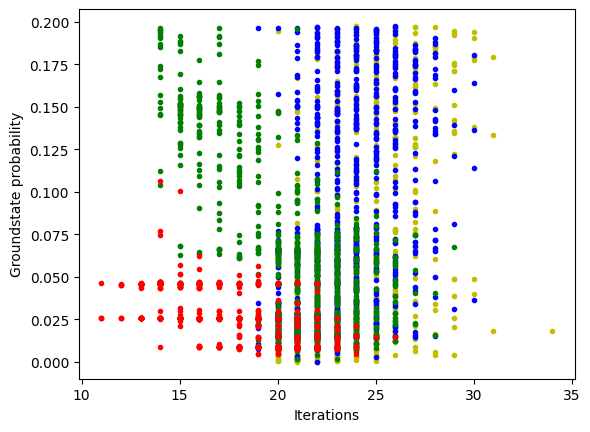

In [102]:
#Både denna och nästa cell ska tas bort så att dataanalysen istället görs i Data_analysis notebooken 

fig, ax = plt.subplots()
for prob_vector in data_library['data_for_alpha_1.0']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'y.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.25']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'b.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.1']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'g.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.05']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'r.', linewidth=0.01)
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.show()

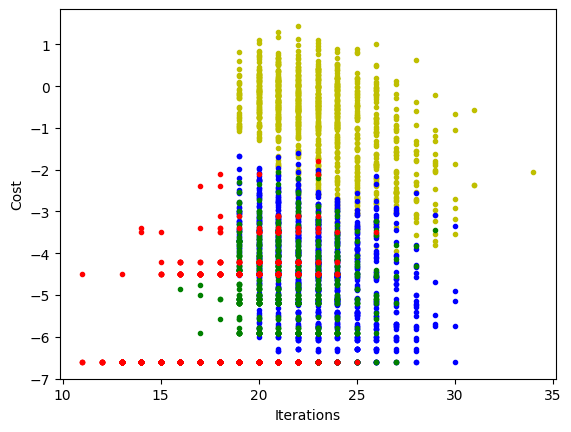

In [103]:
fig, ax = plt.subplots()
for cost_vector in data_library['data_for_alpha_1.0']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'y.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.25']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'b.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.1']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'g.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.05']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'r.', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()